# Machine Learning

This part will train additional networks to predict C-beta positions as well.

We begin with some initial classes and functions to load data

In [2]:
import random
import numpy as np
import torch
import sys
import pandas as pd

class Dataset(torch.utils.data.Dataset):
# optional parameters allow target data to be shifted and scaled
    def __init__(self, target, data):
        self.label = target.astype(np.float32)
# assumes that data is prepared in correct shape beforehand
        self.input = data
    def __len__(self):
        return self.label.shape[0]
    def __getitem__(self, index):
        return self.input[index].astype(np.float32), self.label[index]
    
def randomsplitdata(target_input_fn,training_fraction,maxrows=-1,select="CACNO",aa='all'):
    f=open(target_input_fn)
    lsplit=f.readline().split()
    f.close()

    if (maxrows>0):
        df=pd.read_csv(target_input_fn,sep=' ',header=None,nrows=maxrows)
    else:
        df=pd.read_csv(target_input_fn,sep=' ',header=None)
        
    if (aa == 'all'):
        dfaa=df
    else:
        aalist=aa.split(':')
        dfaa=df.loc[df[0].isin(aalist)]
       
    if (select == "CACNO"): 
        dft=dfaa[[*range(1,13)]]                                                 #ca, c, n, o
    elif (select == "CANCO"):
        dft=dfaa[[*range(1,4)]+[*range(7,10)]+[*range(4,7)]+[*range(10,13)]]     #ca, n, c, o
    elif (select == "CAN"):
        dft=dfaa[[*range(1,4)]+[*range(7,10)]]                                   #ca, n
    elif (select == "CAC"):
        dft=dfaa[[*range(1,7)]]                                                  #ca, c
    elif (select == "CACN"):
        dft=dfaa[[*range(1,10)]]                                                 #ca, c, n
    elif (select == "CA"):
        dft=dfaa[[*range(1,4)]]
    elif (select == "CACNOCB"):
        dft=dfaa[[*range(1,16)]]
    elif (select == "CANCOCB"):
        dft=dfaa[[*range(1,4)]+[*range(7,10)]+[*range(4,7)]+[*range(10,16)]]     #ca, n, c, o
    else:
        print('unknown selection')
        sys.exit(1)
      
    targetdata=dft.to_numpy()
    
    print(targetdata.shape)

    dfi=dfaa[[*range(len(lsplit)-30,len(lsplit))]]
    inputdata=np.reshape(dfi.to_numpy(),(len(dfi),1,-1))
      
    xlist=[*range(len(lsplit)-30,len(lsplit),3)]
    ylist=[*range(len(lsplit)-30+1,len(lsplit),3)]
    zlist=[*range(len(lsplit)-30+2,len(lsplit),3)]
    
    dfixyz=dfi[xlist+ylist+zlist]
    inpxyzdata=np.reshape(dfixyz.to_numpy(),(len(dfi),3,-1)) 
    
    flag=np.zeros(len(targetdata),dtype=int)
    while np.average(flag)<training_fraction:
        flag[random.randint(0,len(targetdata)-1)]=1
    
    target_training=targetdata[np.nonzero(flag)].copy()
    target_validation=targetdata[np.nonzero(1-flag)].copy()
    input_training=inputdata[np.nonzero(flag)].copy()
    input_validation=inputdata[np.nonzero(1-flag)].copy()
    inputxyz_training=inpxyzdata[np.nonzero(flag)].copy()
    inputxyz_validation=inpxyzdata[np.nonzero(1-flag)].copy()
        
    return target_training,input_training,inputxyz_training, \
           target_validation,input_validation,inputxyz_validation

def get_loaders(target_input_fn,training_fraction,batch_size=128,maxrows=-1,aa='all',select="CACNO"):
    [ttarget,tinput,tinpxyz,vtarget,vinput,vinpxyz]=\
        randomsplitdata(target_input_fn,training_fraction,maxrows=maxrows,aa=aa,select=select) 
    
    train_set=Dataset(ttarget,tinput)
    validation_set=Dataset(vtarget,vinput)
    trainxyz_set=Dataset(ttarget,tinpxyz)
    valixyz_set=Dataset(vtarget,vinpxyz)
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=1)
    
    trainxyz_loader = torch.utils.data.DataLoader(trainxyz_set, batch_size=batch_size, shuffle=True)
    valixyz_loader = torch.utils.data.DataLoader(valixyz_set, batch_size=1)
    
    return train_loader,validation_loader,trainxyz_loader,valixyz_loader        

We set up training functions again.

In [3]:
import numpy as np

def train(m,loss_fn,opt,loader,xscale=1.0,klfactor=0.0,klindex=0):
    klloss=nn.KLDivLoss(reduction='batchmean')
    
    loss_sum = 0.0
    for input, label in loader:
        opt.zero_grad()
        
        output = m(input)               # this is where the model is evaluated
        
        loss =  loss_fn(output, label)  # model loss for x       
        
        if (xscale>1.0000001 or xscale<0.9999999):
            nval=output.size(dim=1)
            for n in (range(0,nval,3)):
                loss += loss_fn(output[:,n], label[:,n])*(xscale-1.0)
        
        loss_sum += loss.item()         # accumulate MSE loss
            
        if (klfactor>0):
            loss=loss+klfactor*\
                klloss(output[:,klindex],label[:,klindex])
            
        loss.backward()                 # this calculates the back-propagated loss
        opt.step()                      # this carries out the gradient descent
    
    return loss_sum / len(loader)       # Note: KL loss is not included in reported loss

def validate(m,loss_fn,loader,xscale=1.0):
    loss_sum = 0.0
    for input, label in loader:
        with torch.no_grad():
            output = m(input)

        loss = loss_fn(output, label)

        if (xscale>1.0000001 or xscale<0.9999999):
            nval=output.size(dim=1)
            for n in (range(0,nval,3)):
                loss += loss_fn(output[:,n], label[:,n])*(xscale-1.0)
        
        loss_sum += loss.item()
    return loss_sum / len(loader)

def do_training(m,opt,tloader,vloader,epochs,output,xscale=1.0,klfactor=0.0,klindex=0):
    # use MSE loss fucntion
    loss_fn = nn.MSELoss()
    
    tloss=np.zeros(epochs)
    vloss=np.zeros(epochs)

    for i in range(epochs):
        tloss[i] = train(m,loss_fn,opt,tloader,xscale,klfactor,klindex)
        vloss[i] = validate(m,loss_fn,vloader,xscale)
        if (output):
            print (i, tloss[i], vloss[i])
            
    return tloss,vloss


We also define some plotting functions

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

def plot_progress(epochs,tloss,vloss):
    plt.rcParams["figure.figsize"]=(6,4)
    epoch_index=np.arange(epochs)
    plt.plot(epoch_index,np.log(tloss),color='r',label='training')
    plt.plot(epoch_index,np.log(vloss),color='b',label='validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

def plot_validation(loader,m,inx=0):    
    targetx=[]
    targety=[]
    targetz=[]
    
    predictionx=[]
    predictiony=[]
    predictionz=[]

    for input, label in loader:        
        with torch.no_grad():
            output = m(input)
                 
        targetx+=[label[0,inx*3+0].item()]
        targety+=[label[0,inx*3+1].item()]
        targetz+=[label[0,inx*3+2].item()]
        
        predictionx+=[output[0,inx*3+0].item()]
        predictiony+=[output[0,inx*3+1].item()]
        predictionz+=[output[0,inx*3+2].item()]
    
    plt.rcParams["figure.figsize"]=(12,3)

    fig,ax = plt.subplots(1,3)
    
    minval=np.min(targetx)
    maxval=np.max(targetx)
    lin=np.linspace(minval-0.1*(maxval-minval),maxval+0.1*(maxval-minval),num=100)
    
    ax[0].plot(lin,lin,'k',linewidth=2)
    ax[0].plot(targetx,predictionx,'ro',markersize=2)
    ax[0].set(xlabel='target x [nm]', ylabel="prediction [nm]")
    
    minval=np.min(targety)
    maxval=np.max(targety)
    lin=np.linspace(minval-0.1*(maxval-minval),maxval+0.1*(maxval-minval),num=100)

    ax[1].plot(lin,lin,'k',linewidth=2)
    ax[1].plot(targety,predictiony,'ro',markersize=2)
    ax[1].set(xlabel='target y [nm]', ylabel="")

    minval=np.min(targetz)
    maxval=np.max(targetz)
    lin=np.linspace(minval-0.1*(maxval-minval),maxval+0.1*(maxval-minval),num=100)

    ax[2].plot(lin,lin,'k',linewidth=2)
    ax[2].plot(targetz,predictionz,'ro',markersize=2)    
    ax[2].set(xlabel='target z [nm]', ylabel="")
    
    plt.show()
    
def linear_regression_output(x,y,txt):
    x=np.reshape(np.array(x),(-1,1))
    y=np.reshape(np.array(y),(-1,1))
    linmodel=LinearRegression().fit(x,y)
    r2=linmodel.score(x,y)
    mval=linmodel.coef_[0]
    nval=linmodel.intercept_
    print(f'{txt}: r2 {r2} slope {mval[0]} offset {nval[0]}')
    
def linear_regression(loader,m,inx=0):    
    targetx=[]
    targety=[]
    targetz=[]
    
    predictionx=[]
    predictiony=[]
    predictionz=[]

    for input, label in loader:        
        with torch.no_grad():
            output = m(input)
                 
        targetx+=[label[0,inx*3+0].item()]
        targety+=[label[0,inx*3+1].item()]
        targetz+=[label[0,inx*3+2].item()]
        
        predictionx+=[output[0,inx*3+0].item()]
        predictiony+=[output[0,inx*3+1].item()]
        predictionz+=[output[0,inx*3+2].item()]
    
    linear_regression_output(targetx,predictionx,"x")
    linear_regression_output(targety,predictiony,"y")
    linear_regression_output(targetz,predictionz,"z")

Next we define the neural network models

Model1D3_ca_n_co_cb extends Model1D3_ca_n_co_cb to first predict CA,N,C/O using previously trained weights and then to predict CB

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F          
    
class Model1D3_ca_n_co_cb(nn.Module):
    def __init__(self):
        super(Model1D3_ca_n_co_cb, self).__init__()
        # define layers to be used
        self.conv_1 = nn.Conv1d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv_3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv_4 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv_f = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        # dimensional flattening
        self.flatten = nn.Flatten(start_dim=1) 
        # fully connected layers
        self.fc_1 = nn.Linear(640,128)
        self.fc_2 = nn.Linear(128,32)
        self.fc_f = nn.Linear(32, 3)

        self.cn_1 = nn.Conv1d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.cn_2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.cn_3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.cn_4 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.cn_f = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        # fully connected layers
        self.fcn_1 = nn.Linear(704,128)
        self.fcn_2 = nn.Linear(128,32)
        self.fcn_f = nn.Linear(32, 3)
        
        self.cco_1 = nn.Conv1d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.cco_2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.cco_3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.cco_4 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.cco_f = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        # fully connected layers
        self.fcco_1 = nn.Linear(768,128)
        self.fcco_2 = nn.Linear(128,32)
        self.fcco_f = nn.Linear(32, 6)

        self.ccb_1 = nn.Conv1d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.ccb_2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.ccb_3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.ccb_4 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.ccb_f = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        # fully connected layers
        self.fccb_1 = nn.Linear(896,128)
        self.fccb_2 = nn.Linear(128,32)
        self.fccb_f = nn.Linear(32, 3)

    def forward(self, x):
        # back-propagation is done automatically
        xinp=x
        x = self.conv_1(xinp)
        x = F.relu(self.conv_2(x))
        x = F.relu(self.conv_3(x))
        x = F.relu(self.conv_4(x))
        x = F.relu(self.conv_f(x))
        x = self.flatten(x)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x)) 
        ca = self.fc_f(x)       
       
        car=ca.reshape(-1,3,1)
        x = torch.cat((car,xinp),2)
        x = self.cn_1(x)
        x = F.relu(self.cn_2(x))
        x = F.relu(self.cn_3(x))
        x = F.relu(self.cn_4(x))
        x = F.relu(self.cn_f(x))
        x = self.flatten(x)
        x = F.relu(self.fcn_1(x))
        x = F.relu(self.fcn_2(x)) 
        n = self.fcn_f(x)       
        
        nr=n.reshape(-1,3,1)
        x = torch.cat((car,nr,xinp),2)
        x = self.cco_1(x)
        x = F.relu(self.cco_2(x))
        x = F.relu(self.cco_3(x))
        x = F.relu(self.cco_4(x))
        x = F.relu(self.cco_f(x))
        x = self.flatten(x)
        #print(x.size())
        x = F.relu(self.fcco_1(x))
        x = F.relu(self.fcco_2(x)) 
        co = self.fcco_f(x)       
        c = co[:,0:3]
        ox = co[:,3:6]
        
        cr=c.reshape(-1,3,1)
        oxr=ox.reshape(-1,3,1)
        x = torch.cat((car,nr,cr,oxr,xinp),2)
        x = self.ccb_1(x)
        x = F.relu(self.ccb_2(x))
        x = F.relu(self.ccb_3(x))
        x = F.relu(self.ccb_4(x))
        x = F.relu(self.ccb_f(x))
        x = self.flatten(x)
        #print(x.size())
        x = F.relu(self.fccb_1(x))
        x = F.relu(self.fccb_2(x)) 
        x = self.fccb_f(x)       
               
        x = torch.cat((ca,n,c,ox,x),1)
        return x
    
    def initialize_weights(self, m):
        # initialization of weights, setting them to zero is not good
        if hasattr(m, 'weight') and m.weight.dim() > 1:
            nn.init.xavier_uniform_(m.weight.data)


Now we are training the models using the pretrained weights for specific amino acids.

(41804, 15)
0 0.013436091852120378 0.005850011643546447
1 0.003576249335751389 0.002001119496077281
2 0.0013274579850434693 0.0010870179441277443
3 0.0010104511368836304 0.0009102116868633853
4 0.0009244926138004909 0.0008158476847219147
5 0.0008871483635933449 0.0008420651549831594
6 0.0008543482417184296 0.0007737649821263003
7 0.0008381632867509104 0.0007582582510456797
8 0.0008224922375203195 0.000756125308907396
9 0.0008186758875098983 0.0007602114665322127


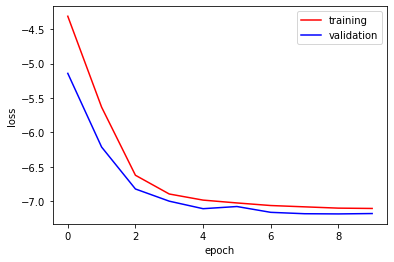

CA


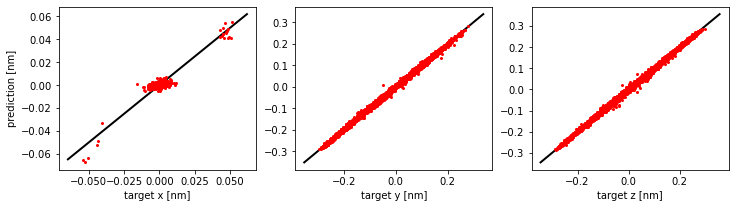

x: r2 0.7058435916001096 slope 0.7348743646965076 offset 0.00032208765190234936
y: r2 0.9993721582272391 slope 0.9964776891663213 offset -0.0007118860608202604
z: r2 0.9982076205096513 slope 0.998012037050874 offset 0.0009342505919869484
N


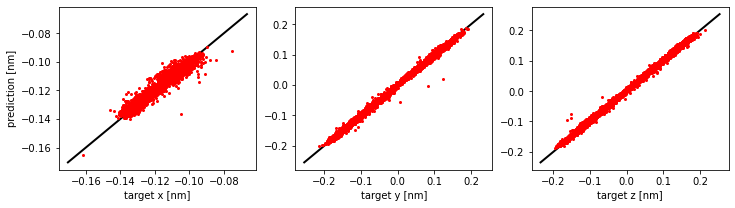

x: r2 0.9470949094274628 slope 0.9595413427821032 offset -0.00393535848956246
y: r2 0.9984467372767672 slope 0.9939902650265463 offset 0.0005817584789787333
z: r2 0.9975264672291668 slope 0.9965246843879165 offset 0.003152541720301223
C


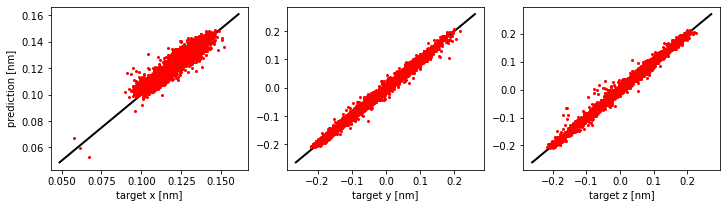

x: r2 0.8845904947249992 slope 0.8989314846053581 offset 0.013981546810284518
y: r2 0.9962488072362491 slope 0.9920858487193608 offset -3.935286070912147e-05
z: r2 0.9913923134229553 slope 0.9978738546652518 offset 0.0010807185192105231
O


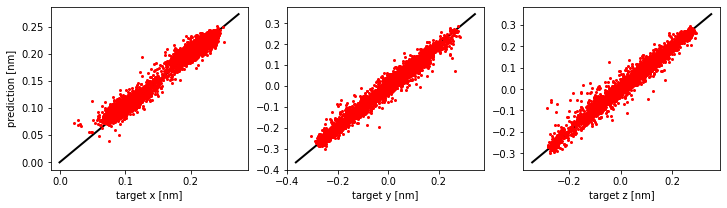

x: r2 0.9722873544488452 slope 0.9676503274434829 offset 0.008075289603728747
y: r2 0.9871447523238377 slope 0.9728894983776695 offset -0.0021334803328349056
z: r2 0.975665103286774 slope 0.9798128206587633 offset 0.005117364345830155
CB


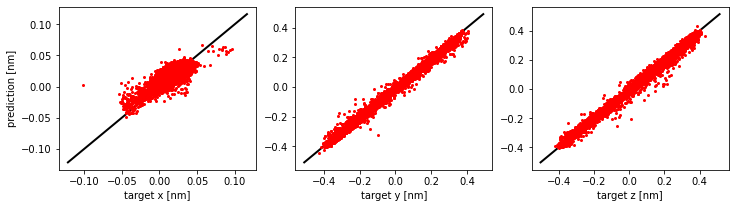

x: r2 0.7668598736102126 slope 0.8277898794426746 offset 0.0065341144559953705
y: r2 0.9960553643693931 slope 0.987580512112248 offset -0.012110234356881078
z: r2 0.990570887264707 slope 0.9773589753046074 offset -0.006830077012785811


In [6]:
aa='ALA'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCOCB") 

m = Model1D3_ca_n_co_cb()
m.apply(m.initialize_weights)
m.zero_grad()

# load partial weights from previous model
# may use other models previously trained 
m.load_state_dict(torch.load(f'{aa}_1d3_ca_n_co_predict_aa.dict'),strict=False)

# disable training of all weights
for param in m.parameters():
    param.requires_grad = False

# reenable training of only the second part of the network that predicts Cbetas 
# this means that the CA/N/CO prediction is not changed during training
for param in m.ccb_1.parameters():
    param.requires_grad = True
for param in m.ccb_2.parameters():
    param.requires_grad = True
for param in m.ccb_3.parameters():
    param.requires_grad = True
for param in m.ccb_4.parameters():
    param.requires_grad = True
for param in m.ccb_f.parameters():
    param.requires_grad = True   
for param in m.fccb_1.parameters():
    param.requires_grad = True
for param in m.fccb_2.parameters():
    param.requires_grad = True
for param in m.fccb_f.parameters():
    param.requires_grad = True

# optimizer with extra options to only train certain weights
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0005, weight_decay=0.00001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=1.0,klindex=12)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

print('CB')
plot_validation(vxyzloader,m,4)
linear_regression(vxyzloader,m,4)


torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_cb_predict_aa.dict")


(23327, 15)
0 0.013512641946608955 0.008982549527049112
1 0.007919778493610589 0.006997145975701359
2 0.004877094519198747 0.0034221941423861154
3 0.0025913506853268357 0.0021481008071720553
4 0.001785060013266834 0.0015353288644025628
5 0.0013147168037657801 0.001220852940266022
6 0.0011150400969199836 0.001205187351148014
7 0.001005768370059495 0.0010490972555369453
8 0.0009694102100675573 0.0010173140694640862
9 0.0009200951411716036 0.0009749931612354822


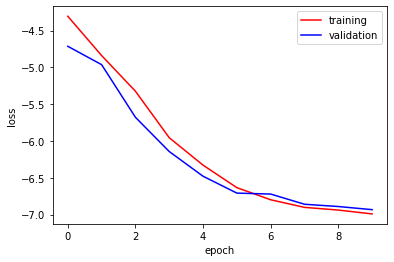

CA


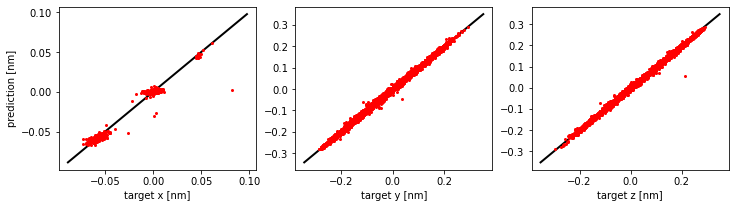

x: r2 0.9679088235973365 slope 0.9634995292079244 offset -0.0004167550437529895
y: r2 0.9981186796233581 slope 0.995784845650161 offset 0.0008507213980876935
z: r2 0.9982487794873672 slope 0.9947417599884967 offset -0.0006900181188304183
N


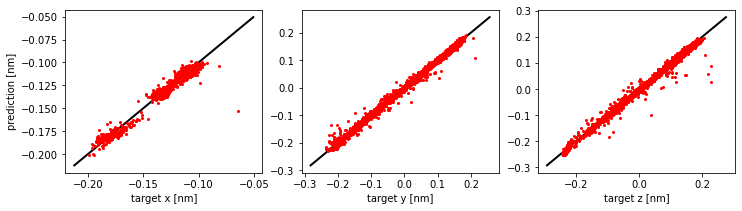

x: r2 0.9651442767923959 slope 0.9643979947447575 offset -0.004667612386355227
y: r2 0.9963900693284046 slope 0.9916789372845202 offset 0.0005453304298385295
z: r2 0.9941175036916319 slope 0.9917504381469263 offset -0.0016214697441514353
C


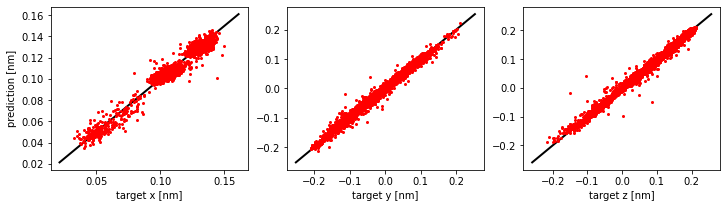

x: r2 0.9564966679137391 slope 0.9616758641086743 offset 0.003747189274188309
y: r2 0.9910168540056038 slope 0.9919994929795211 offset 0.0018072385667792547
z: r2 0.9918311277962892 slope 0.9905000393323873 offset 4.8363347884786134e-05
O


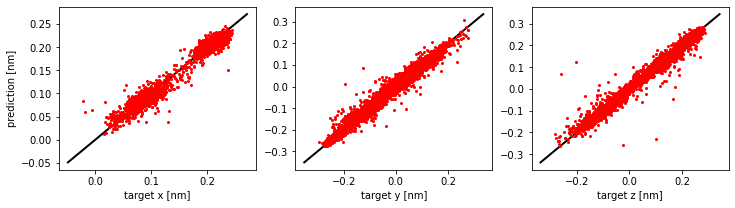

x: r2 0.9747648179701377 slope 0.9699486811465151 offset 0.003137465051347016
y: r2 0.9718261607344986 slope 0.9657291355679186 offset 0.0033981290355909015
z: r2 0.9788131158583716 slope 0.9763910859288252 offset 0.0027351883420260042
CB


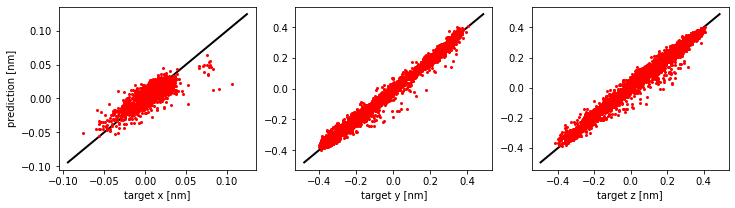

x: r2 0.6713898543798 slope 0.7084399584612716 offset 0.0026084788179246577
y: r2 0.9900808523189665 slope 0.9842312456804602 offset -0.005750204640859541
z: r2 0.9841487755428382 slope 0.9664107869449797 offset 0.006002950318575853


In [7]:
aa='PRO'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCOCB") 

m = Model1D3_ca_n_co_cb()
m.apply(m.initialize_weights)
m.zero_grad()

# load partial weights from previous model
# may use other models previously trained 
m.load_state_dict(torch.load(f'{aa}_1d3_ca_n_co_predict_aa.dict'),strict=False)

# disable training of all weights
for param in m.parameters():
    param.requires_grad = False

# reenable training of only the second part of the network that predicts Cbetas 
# this means that the CA/N/CO prediction is not changed during training
for param in m.ccb_1.parameters():
    param.requires_grad = True
for param in m.ccb_2.parameters():
    param.requires_grad = True
for param in m.ccb_3.parameters():
    param.requires_grad = True
for param in m.ccb_4.parameters():
    param.requires_grad = True
for param in m.ccb_f.parameters():
    param.requires_grad = True   
for param in m.fccb_1.parameters():
    param.requires_grad = True
for param in m.fccb_2.parameters():
    param.requires_grad = True
for param in m.fccb_f.parameters():
    param.requires_grad = True

# optimizer with extra options to only train certain weights
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0005, weight_decay=0.00001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=1.0,klindex=12)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

print('CB')
plot_validation(vxyzloader,m,4)
linear_regression(vxyzloader,m,4)


torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_cb_predict_aa.dict")


(35728, 15)
0 0.011533833183680795 0.006839643711676499
1 0.003961960814194754 0.001987532048612986
2 0.0014380277966016106 0.001062824271148017
3 0.001096423004388011 0.0009732132919534318
4 0.0010283837047089556 0.0008962673831417048
5 0.0009930827228734934 0.0009918124171918112
6 0.0009885527792253665 0.0008909977287201628
7 0.0009638125713016572 0.0008804734475861544
8 0.000935688687604852 0.0008712883298485356
9 0.0009599230636792656 0.0008134288936253206


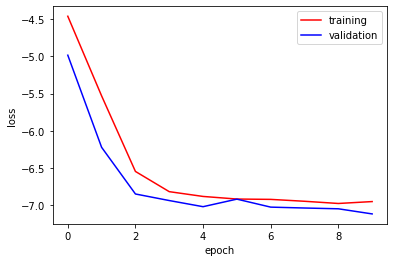

CA


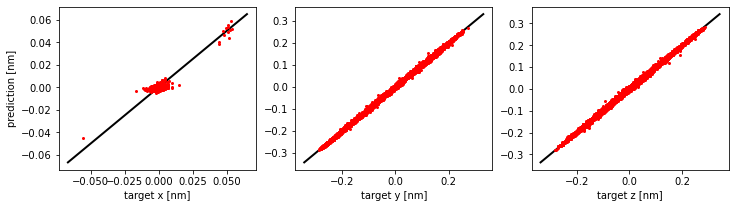

x: r2 0.677389141119477 slope 0.6729365655852478 offset -0.00015034793179181295
y: r2 0.999512374466172 slope 1.001277852622975 offset 0.00025520920933377184
z: r2 0.9980649177709312 slope 0.9946383895276283 offset 0.0012769487704518754
N


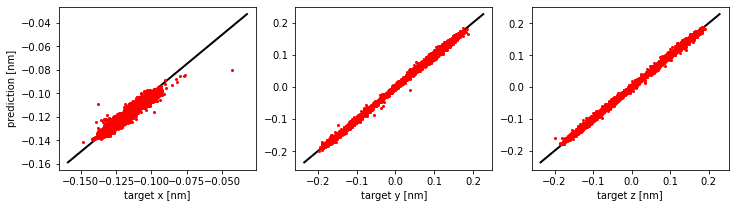

x: r2 0.9391435102623511 slope 0.9308311624701309 offset -0.008863767917015458
y: r2 0.9987218919462845 slope 1.0018800872240086 offset -0.0006274638501773747
z: r2 0.997583724215806 slope 0.99048556717852 offset 0.0009851004803747333
C


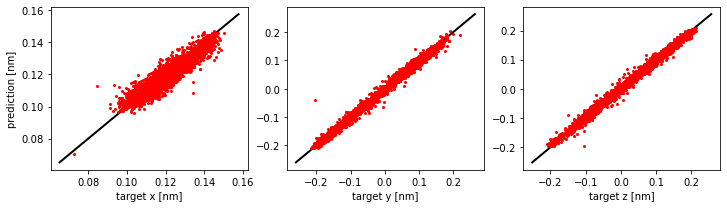

x: r2 0.8353736331433765 slope 0.858690071389138 offset 0.015815668488722262
y: r2 0.9965244965162419 slope 0.9933967040511014 offset -0.0012040252908020015
z: r2 0.9919418987102419 slope 0.9801003786430836 offset 0.0018163674040039338
O


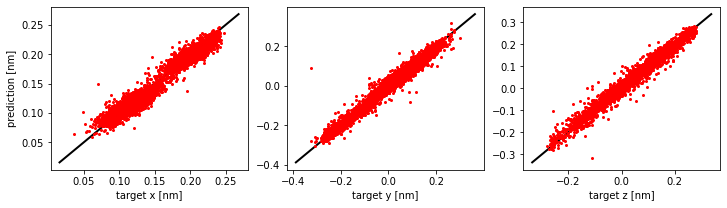

x: r2 0.959373588485971 slope 0.9740998551830139 offset 0.0022504556571747714
y: r2 0.986837783206242 slope 0.9781044296035875 offset -0.0019084211412328106
z: r2 0.9766299316851603 slope 0.9591917382735107 offset 0.007226695611372319
CB


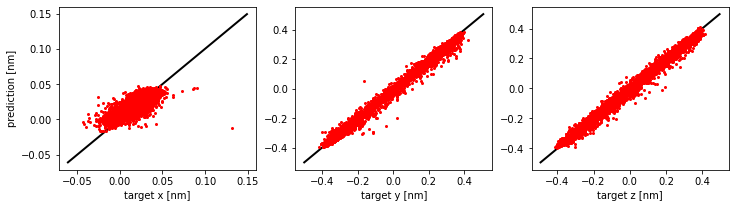

x: r2 0.6895074507982701 slope 0.7463364750959285 offset 0.00656215024598032
y: r2 0.9956103662027924 slope 0.9832088878450894 offset -0.008305082242326964
z: r2 0.9890892383350756 slope 0.9764602219450979 offset -0.00395374326983643


In [8]:
aa='VAL'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCOCB") 

m = Model1D3_ca_n_co_cb()
m.apply(m.initialize_weights)
m.zero_grad()

# load partial weights from previous model
# may use other models previously trained 
m.load_state_dict(torch.load(f'{aa}_1d3_ca_n_co_predict_aa.dict'),strict=False)

# disable training of all weights
for param in m.parameters():
    param.requires_grad = False

# reenable training of only the second part of the network that predicts Cbetas 
# this means that the CA/N/CO prediction is not changed during training
for param in m.ccb_1.parameters():
    param.requires_grad = True
for param in m.ccb_2.parameters():
    param.requires_grad = True
for param in m.ccb_3.parameters():
    param.requires_grad = True
for param in m.ccb_4.parameters():
    param.requires_grad = True
for param in m.ccb_f.parameters():
    param.requires_grad = True   
for param in m.fccb_1.parameters():
    param.requires_grad = True
for param in m.fccb_2.parameters():
    param.requires_grad = True
for param in m.fccb_f.parameters():
    param.requires_grad = True

# optimizer with extra options to only train certain weights
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0005, weight_decay=0.00001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=2.0,klindex=12)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

print('CB')
plot_validation(vxyzloader,m,4)
linear_regression(vxyzloader,m,4)


torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_cb_predict_aa.dict")


(45313, 15)
0 0.0074395712064972645 0.003206783928770388
1 0.002289672790449375 0.0014340332070213876
2 0.0013503917643774143 0.0014650467210152716
3 0.0012411801554393811 0.0010286619866818518
4 0.0011450584763070752 0.0010600581558025553
5 0.0011279565777341035 0.0009637946981202761
6 0.001093020108462849 0.0009733299945731363
7 0.0010821110713230052 0.000935392955587816
8 0.0010669415408391242 0.0009325680090736528
9 0.0010757455840037847 0.000867446817252145


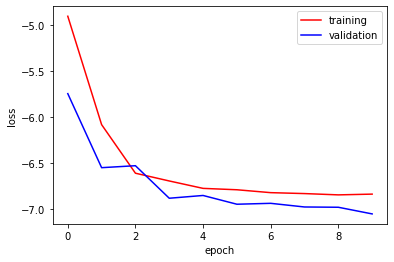

CA


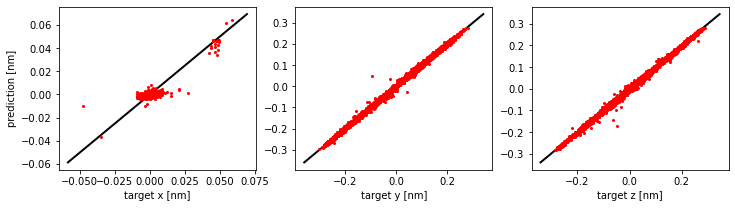

x: r2 0.6637053402304182 slope 0.6340979418342988 offset -0.0002369309337117284
y: r2 0.9994411070423769 slope 1.0040257372410761 offset 0.0010202473380576532
z: r2 0.997961783829934 slope 1.0002836177583014 offset -0.0009130349391783897
N


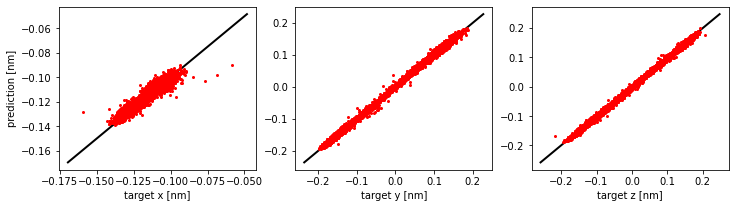

x: r2 0.9435092216619004 slope 0.9160544257490669 offset -0.00936321916635506
y: r2 0.9987884965088474 slope 1.007185066502711 offset 0.001212564456254575
z: r2 0.9979363936703469 slope 1.0025101195666433 offset -0.0014127794681735757
C


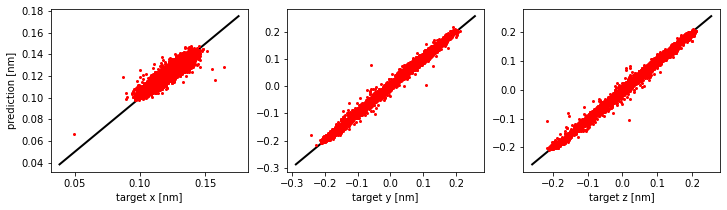

x: r2 0.8541715932951435 slope 0.8404387523254193 offset 0.019752278039985527
y: r2 0.9964916071025213 slope 1.0076364807220903 offset 0.00334598959250057
z: r2 0.9912839889529464 slope 0.9969198017836259 offset -0.0015942253598737813
O


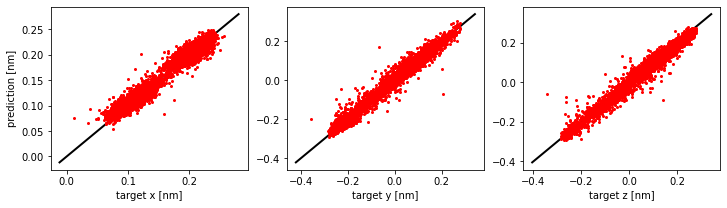

x: r2 0.9635054254435486 slope 0.9418334023815016 offset 0.0108831981585234
y: r2 0.9863213107351186 slope 1.0049719518045004 offset 0.005387581435075728
z: r2 0.9754593905667026 slope 0.9871459954511835 offset -0.0017773486566194652
CB


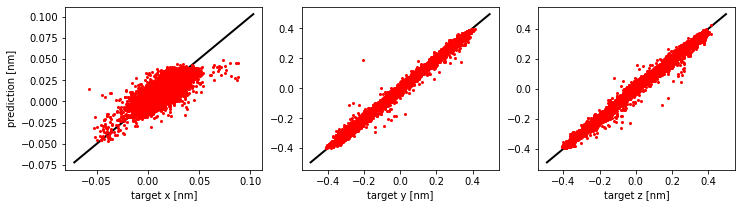

x: r2 0.700561300229271 slope 0.7863237652961744 offset 0.0026939680536621543
y: r2 0.996751909999059 slope 1.0024091887264053 offset -0.004128362514049896
z: r2 0.9906196873296231 slope 0.9821362618222915 offset 0.0014299416728369568


In [9]:
aa='LEU'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCOCB") 

m = Model1D3_ca_n_co_cb()
m.apply(m.initialize_weights)
m.zero_grad()

# load partial weights from previous model
# may use other models previously trained 
m.load_state_dict(torch.load(f'{aa}_1d3_ca_n_co_predict_aa.dict'),strict=False)

# disable training of all weights
for param in m.parameters():
    param.requires_grad = False

# reenable training of only the second part of the network that predicts Cbetas 
# this means that the CA/N/CO prediction is not changed during training
for param in m.ccb_1.parameters():
    param.requires_grad = True
for param in m.ccb_2.parameters():
    param.requires_grad = True
for param in m.ccb_3.parameters():
    param.requires_grad = True
for param in m.ccb_4.parameters():
    param.requires_grad = True
for param in m.ccb_f.parameters():
    param.requires_grad = True   
for param in m.fccb_1.parameters():
    param.requires_grad = True
for param in m.fccb_2.parameters():
    param.requires_grad = True
for param in m.fccb_f.parameters():
    param.requires_grad = True

# optimizer with extra options to only train certain weights
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0005, weight_decay=0.00001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=2.0,klindex=12)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

print('CB')
plot_validation(vxyzloader,m,4)
linear_regression(vxyzloader,m,4)


torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_cb_predict_aa.dict")


(20897, 15)
0 0.01029651185892748 0.007064085099404867
1 0.005221848615981413 0.0036593896021964198
2 0.0030506541740826583 0.0023783209927444164
3 0.0019339047809780548 0.0015082068794487937
4 0.0015334738630124114 0.001556882341953017
5 0.0013579336122017014 0.0012197081985424105
6 0.0013635155046358705 0.0014206523098562749
7 0.0012512374316539729 0.0011343045309656211
8 0.0012597363745567925 0.0011374781620910846
9 0.0012204333518942196 0.001138815490917242


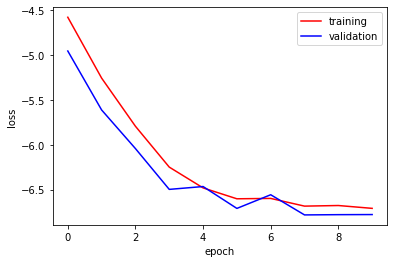

CA


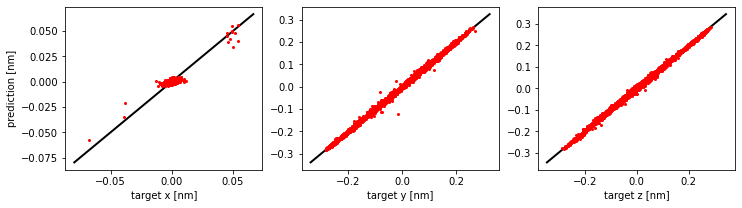

x: r2 0.7550651315724998 slope 0.6995985863233235 offset -2.0137079396152373e-06
y: r2 0.9991884178442972 slope 0.9998192942259314 offset -0.00014945824740675295
z: r2 0.9978683684634987 slope 0.9946082312784742 offset -1.8268916567804397e-05
N


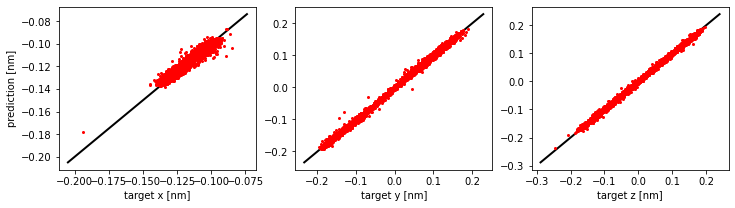

x: r2 0.9343451871256092 slope 0.9044086326843495 offset -0.010609200496420598
y: r2 0.9981212335684926 slope 1.0022847896250442 offset -4.379816262408548e-05
z: r2 0.997237156799681 slope 0.9904923201183701 offset 0.0007092053733367557
C


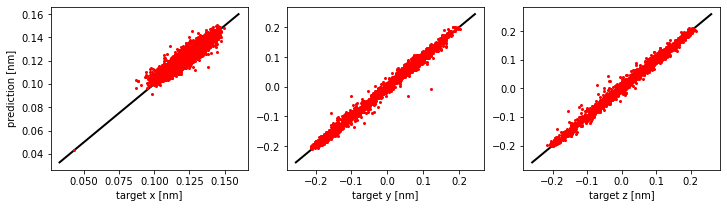

x: r2 0.8590857617584049 slope 0.8569352307682798 offset 0.01843330849674471
y: r2 0.9946191700467177 slope 1.0020656664782652 offset 0.0013611813482650517
z: r2 0.9892557518474681 slope 0.9884333744734848 offset 0.0026306292176680873
O


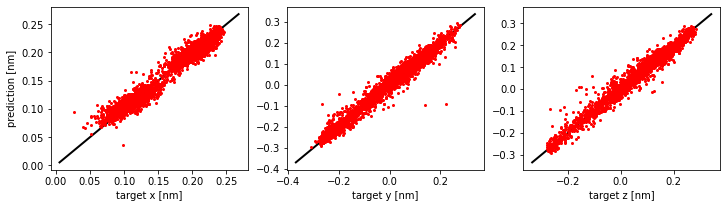

x: r2 0.9614973508433966 slope 0.9441938038737825 offset 0.009838073430681271
y: r2 0.980489835785026 slope 0.9857314155522485 offset 0.0021249320185181275
z: r2 0.9711392858986576 slope 0.9668373124121535 offset 0.005028608867900519
CB


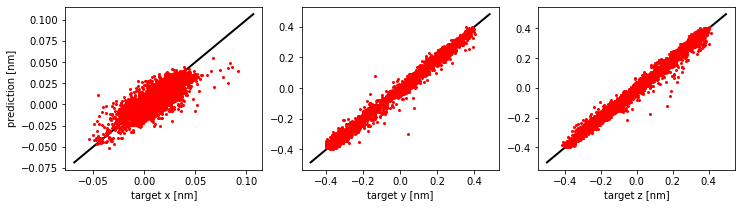

x: r2 0.698591972348821 slope 0.7553147761957788 offset -0.00031966895765516735
y: r2 0.9934743611137553 slope 0.9883923964314145 offset -0.005955168052038225
z: r2 0.9836705653728168 slope 0.9730109936563061 offset -0.003860787829127431


In [10]:
aa='PHE'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCOCB") 

m = Model1D3_ca_n_co_cb()
m.apply(m.initialize_weights)
m.zero_grad()

# load partial weights from previous model
# may use other models previously trained 
m.load_state_dict(torch.load(f'{aa}_1d3_ca_n_co_predict_aa.dict'),strict=False)

# disable training of all weights
for param in m.parameters():
    param.requires_grad = False

# reenable training of only the second part of the network that predicts Cbetas 
# this means that the CA/N/CO prediction is not changed during training
for param in m.ccb_1.parameters():
    param.requires_grad = True
for param in m.ccb_2.parameters():
    param.requires_grad = True
for param in m.ccb_3.parameters():
    param.requires_grad = True
for param in m.ccb_4.parameters():
    param.requires_grad = True
for param in m.ccb_f.parameters():
    param.requires_grad = True   
for param in m.fccb_1.parameters():
    param.requires_grad = True
for param in m.fccb_2.parameters():
    param.requires_grad = True
for param in m.fccb_f.parameters():
    param.requires_grad = True

# optimizer with extra options to only train certain weights
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0005, weight_decay=0.00001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=2.0,klindex=12)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

print('CB')
plot_validation(vxyzloader,m,4)
linear_regression(vxyzloader,m,4)


torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_cb_predict_aa.dict")


(28282, 15)
0 0.00862734799997674 0.004380406779199631
1 0.00293447691688521 0.001774809969250894
2 0.001381753604962594 0.0010272044055499923
3 0.001265524182882574 0.0014291807669931848
4 0.0012235735775902867 0.0013664609196219438
5 0.001304437235618631 0.001527053751997725
6 0.0011959759415023858 0.0010951692982608392
7 0.0011483505562258263 0.0010426061925152131
8 0.001160819710801459 0.0009343171855287455
9 0.001144368098013931 0.000977791303769881


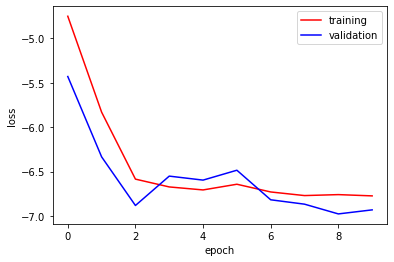

CA


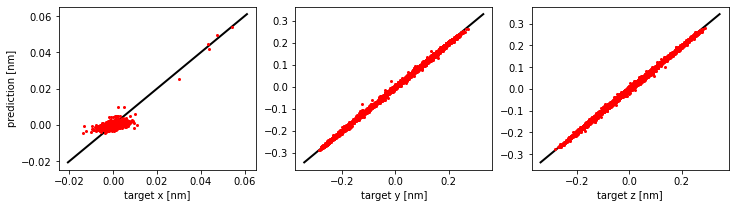

x: r2 0.5061513787294786 slope 0.4949837950293357 offset -0.0001943102535547969
y: r2 0.9995486468842238 slope 0.9957158874687733 offset -0.0006401740801593864
z: r2 0.998055935818704 slope 0.9913115157316942 offset -0.00036015855898864483
N


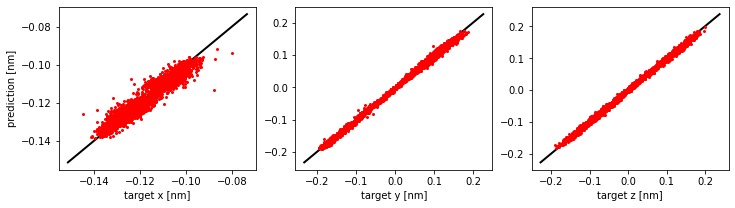

x: r2 0.9322112905695042 slope 0.9224396494156588 offset -0.009378891370171075
y: r2 0.99881954257375 slope 0.9924368100115479 offset -0.0018856497775814364
z: r2 0.9977865107516525 slope 0.9894210307764532 offset -0.00012981726707729426
C


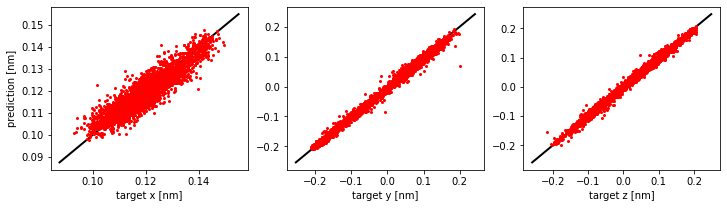

x: r2 0.8223640637198795 slope 0.8479603078297888 offset 0.01804847780841995
y: r2 0.9967747493107894 slope 0.9856040018100535 offset -0.003175889696819055
z: r2 0.992002408575094 slope 0.9871889546822875 offset 0.0006070911563488199
O


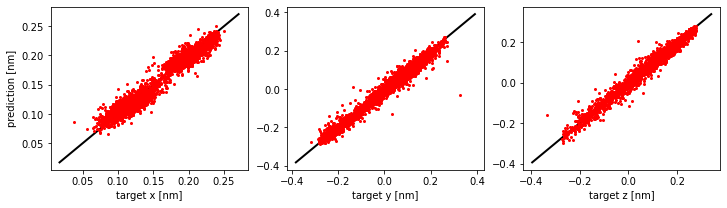

x: r2 0.9560991540522547 slope 0.9644880482183172 offset 0.004613541655370784
y: r2 0.9872486818692696 slope 0.9724354489562269 offset -0.0077452825267460695
z: r2 0.9766371750803704 slope 0.9775528569806723 offset 0.0009250894276101596
CB


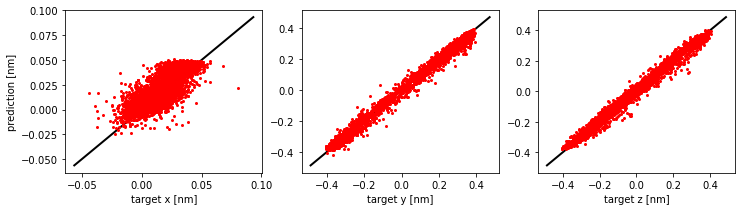

x: r2 0.6928802069584197 slope 0.9499596377659774 offset 0.005519872912975732
y: r2 0.9957115848609508 slope 1.0012340925445167 offset 0.00040892466725958587
z: r2 0.9885974472243976 slope 0.9896197705365847 offset 0.006647866350131558


In [11]:
aa='ILE'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCOCB") 

m = Model1D3_ca_n_co_cb()
m.apply(m.initialize_weights)
m.zero_grad()

# load partial weights from previous model
# may use other models previously trained 
m.load_state_dict(torch.load(f'{aa}_1d3_ca_n_co_predict_aa.dict'),strict=False)

# disable training of all weights
for param in m.parameters():
    param.requires_grad = False

# reenable training of only the second part of the network that predicts Cbetas 
# this means that the CA/N/CO prediction is not changed during training
for param in m.ccb_1.parameters():
    param.requires_grad = True
for param in m.ccb_2.parameters():
    param.requires_grad = True
for param in m.ccb_3.parameters():
    param.requires_grad = True
for param in m.ccb_4.parameters():
    param.requires_grad = True
for param in m.ccb_f.parameters():
    param.requires_grad = True   
for param in m.fccb_1.parameters():
    param.requires_grad = True
for param in m.fccb_2.parameters():
    param.requires_grad = True
for param in m.fccb_f.parameters():
    param.requires_grad = True

# optimizer with extra options to only train certain weights
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0005, weight_decay=0.00001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=3.0,klindex=12)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

print('CB')
plot_validation(vxyzloader,m,4)
linear_regression(vxyzloader,m,4)


torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_cb_predict_aa.dict")


(18999, 15)
0 0.01798766360928615 0.008442506760501732
1 0.007462131806338827 0.005667708379157166
2 0.0043132412014529106 0.002995258553233408
3 0.0026970048823083442 0.0021394400492765627
4 0.001940319462058445 0.002674792163503503
5 0.0017748398977952698 0.0014854710037662663
6 0.001610693494634082 0.0014118400481027513
7 0.0015737139348251125 0.0013069280896487285
8 0.001511493003151069 0.0014329576930393081
9 0.0014643131056800486 0.0015904349944105018
10 0.00144411768609037 0.001405936756555033
11 0.0014270656974986196 0.001299733519563178
12 0.001399679066768537 0.0014916269620452239
13 0.0013881635037250816 0.0015254391935355378
14 0.0013885895682809253 0.0012574246366969324
15 0.001361689561357101 0.0012489480136246291
16 0.0013729673771498104 0.0011699523633168587
17 0.0013711718958802522 0.0012318832362503214
18 0.001375498176397135 0.001852791215672386
19 0.001397464459296316 0.00151574427596838


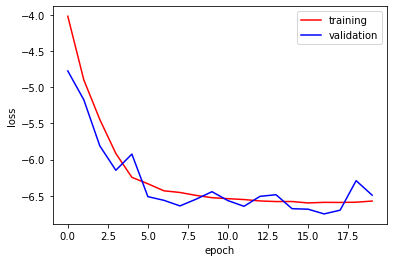

CA


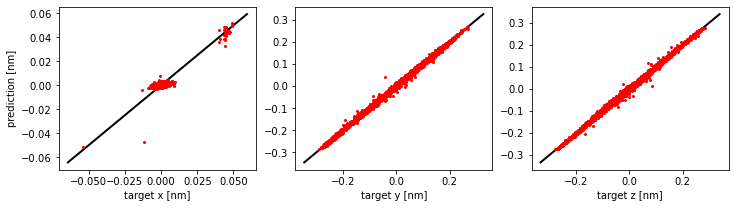

x: r2 0.8215694215898073 slope 0.8259792604200306 offset 0.00039784802155032957
y: r2 0.9991425503985253 slope 1.0001796307378437 offset 0.0007811361850064494
z: r2 0.9973536557936901 slope 1.0009759124061772 offset 0.0005259243241860466
N


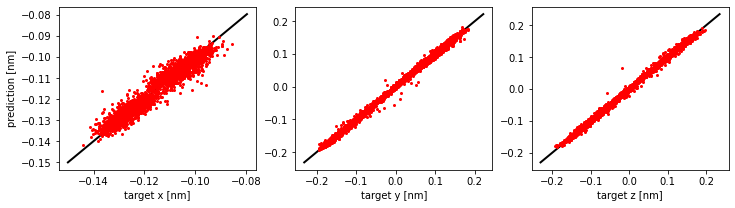

x: r2 0.9355002339322294 slope 0.9372341689267348 offset -0.0073867852114405524
y: r2 0.9979676709284976 slope 1.0001090303413493 offset 0.0004941756666060892
z: r2 0.996353707386145 slope 0.9960188887793343 offset 0.0016711378241549071
C


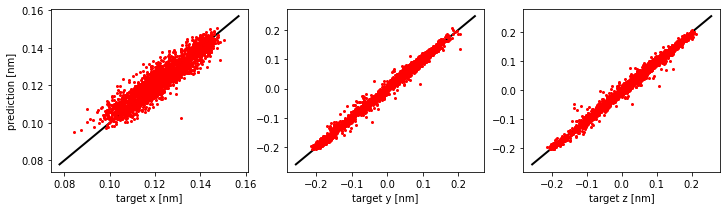

x: r2 0.8539283051562346 slope 0.870182680758201 offset 0.016586551685558087
y: r2 0.9943807802582789 slope 0.9965399700562557 offset 0.001582158453890939
z: r2 0.9870575045323158 slope 0.9931499783741999 offset -0.0007416514425480011
O


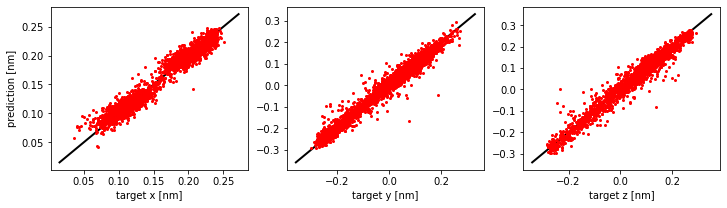

x: r2 0.9616253943051217 slope 0.9603407749836406 offset 0.007357524310416835
y: r2 0.9792474711693674 slope 0.9771861592805289 offset 0.0005732055316256118
z: r2 0.9670785848397572 slope 0.9796302086446905 offset 0.0001643531202045745
CB


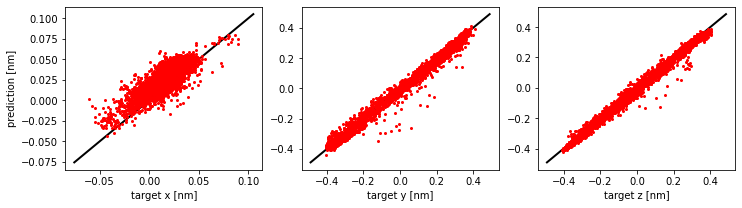

x: r2 0.7205924209236437 slope 0.83822405467166 offset 0.012835189286404649
y: r2 0.9914625267987319 slope 0.9889195114473804 offset -0.00722592492429603
z: r2 0.9874895095610757 slope 0.9862412420768397 offset -0.008343887335816785


In [12]:
aa='TYR'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCOCB") 

m = Model1D3_ca_n_co_cb()
m.apply(m.initialize_weights)
m.zero_grad()

# load partial weights from previous model
# may use other models previously trained 
m.load_state_dict(torch.load(f'{aa}_1d3_ca_n_co_predict_aa.dict'),strict=False)

# disable training of all weights
for param in m.parameters():
    param.requires_grad = False

# reenable training of only the second part of the network that predicts Cbetas 
# this means that the CA/N/CO prediction is not changed during training
for param in m.ccb_1.parameters():
    param.requires_grad = True
for param in m.ccb_2.parameters():
    param.requires_grad = True
for param in m.ccb_3.parameters():
    param.requires_grad = True
for param in m.ccb_4.parameters():
    param.requires_grad = True
for param in m.ccb_f.parameters():
    param.requires_grad = True   
for param in m.fccb_1.parameters():
    param.requires_grad = True
for param in m.fccb_2.parameters():
    param.requires_grad = True
for param in m.fccb_f.parameters():
    param.requires_grad = True

# optimizer with extra options to only train certain weights
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0005, weight_decay=0.00001)

epochs=20
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=3.0,klindex=12)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

print('CB')
plot_validation(vxyzloader,m,4)
linear_regression(vxyzloader,m,4)


torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_cb_predict_aa.dict")


(7761, 15)
0 0.020918639949881114 0.010853064869957756
1 0.009900506084355025 0.009089167539021913
2 0.009369588242127346 0.009027565449830889
3 0.008843711863916654 0.008469674298878802
4 0.008064349074489795 0.007586697463939907
5 0.006860894688333456 0.005870877837428593
6 0.005299442196981265 0.004343658866814293
7 0.003844668300679097 0.0032495059838990913
8 0.003120230009349493 0.002377847329054142
9 0.0024803066088889656 0.0021810626585143725
10 0.0023800250715934313 0.0017279342290392604
11 0.0020320196725571384 0.001949546501701033
12 0.0018957642695078482 0.0016909658063445228
13 0.0017957480785508568 0.0020791183363041087
14 0.0018015138428801526 0.001628381004982507
15 0.001720240285906654 0.0017071725484696537
16 0.0016549522182545983 0.001540812298834371
17 0.0016348530323459553 0.0014612156520546911
18 0.0016384929096182953 0.001858140110011705
19 0.0016634698616913878 0.0015625429438405826


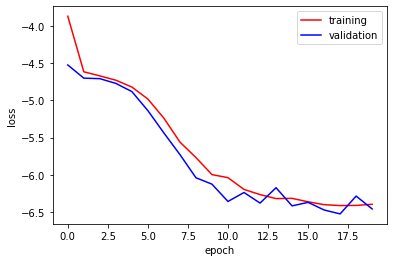

CA


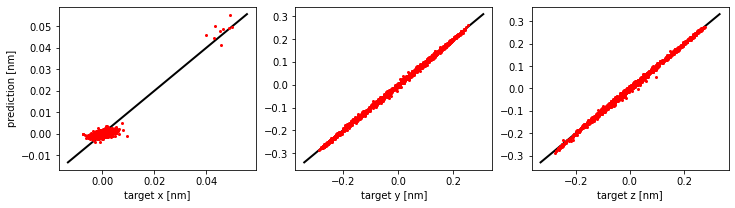

x: r2 0.8308617267595964 slope 0.8657677203107111 offset 0.0002668073158430174
y: r2 0.9992343739014588 slope 0.9953443487053651 offset -0.0012746349094240744
z: r2 0.9978218687603113 slope 0.9993667237145749 offset -3.6803593159139177e-05
N


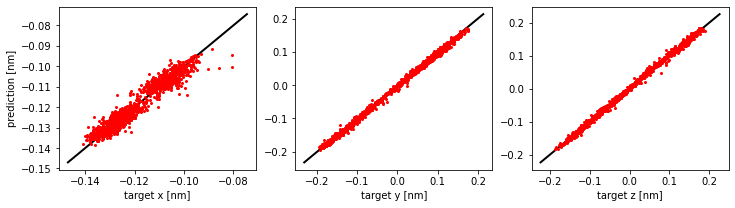

x: r2 0.927484883127269 slope 0.9243795117083152 offset -0.008571359965823047
y: r2 0.9983154222356211 slope 0.9899769258000292 offset -0.0022171987973967217
z: r2 0.9969530747142676 slope 1.005135471593887 offset 0.0015888094762143627
C


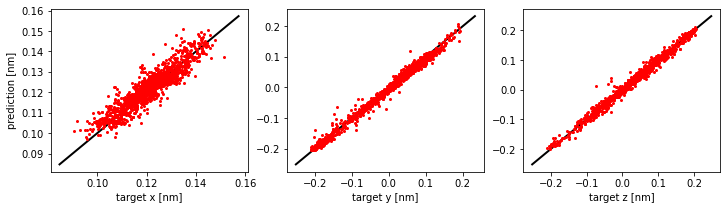

x: r2 0.8436975845994306 slope 0.8944576489642164 offset 0.013886311565855805
y: r2 0.9939054606840887 slope 0.9819895843187566 offset -0.003309126778020352
z: r2 0.9872632692113075 slope 0.9859143989681186 offset 0.0009873261510834688
O


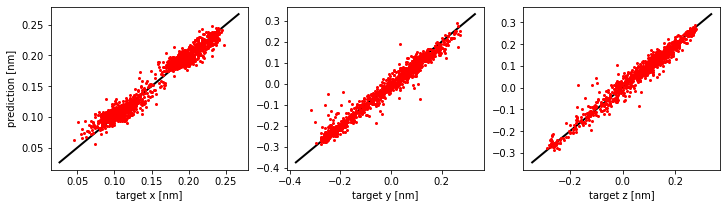

x: r2 0.9621644571934973 slope 0.9572758561665274 offset 0.00806407227548489
y: r2 0.9756741327519387 slope 0.9579237606458203 offset -0.008026170008620784
z: r2 0.9635781145080222 slope 0.9623993559357723 offset 0.0032420433500711388
CB


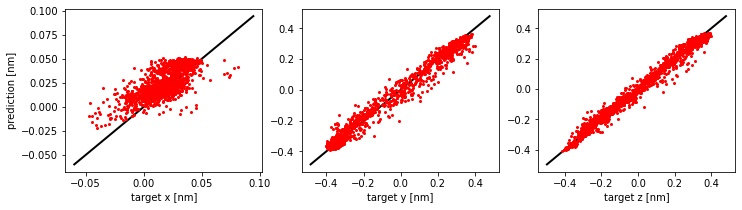

x: r2 0.5411770262501681 slope 0.6679680884882057 offset 0.013984583072456022
y: r2 0.98104151660614 slope 0.9698504751935566 offset -0.0028563927971042707
z: r2 0.9792729366629614 slope 0.9581584109935569 offset 0.001942393777659604


In [13]:
aa='TRP'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCOCB") 

m = Model1D3_ca_n_co_cb()
m.apply(m.initialize_weights)
m.zero_grad()

# load partial weights from previous model
# may use other models previously trained 
m.load_state_dict(torch.load(f'{aa}_1d3_ca_n_co_predict_aa.dict'),strict=False)

# disable training of all weights
for param in m.parameters():
    param.requires_grad = False

# reenable training of only the second part of the network that predicts Cbetas 
# this means that the CA/N/CO prediction is not changed during training
for param in m.ccb_1.parameters():
    param.requires_grad = True
for param in m.ccb_2.parameters():
    param.requires_grad = True
for param in m.ccb_3.parameters():
    param.requires_grad = True
for param in m.ccb_4.parameters():
    param.requires_grad = True
for param in m.ccb_f.parameters():
    param.requires_grad = True   
for param in m.fccb_1.parameters():
    param.requires_grad = True
for param in m.fccb_2.parameters():
    param.requires_grad = True
for param in m.fccb_f.parameters():
    param.requires_grad = True

# optimizer with extra options to only train certain weights
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0005, weight_decay=0.00001)

epochs=20
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=3.0,klindex=12)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

print('CB')
plot_validation(vxyzloader,m,4)
linear_regression(vxyzloader,m,4)


torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_cb_predict_aa.dict")


(30250, 15)
0 0.023282919990985345 0.009539189020918359
1 0.008791061700321734 0.007721000269328606
2 0.005747524128916363 0.0038890601750795175
3 0.0030804029132317132 0.001846684233064442
4 0.0018476399103140768 0.001520203054666532
5 0.0017161220360624914 0.0013616446623001882
6 0.0015177311967515077 0.0018406980995490257
7 0.0015339066618859458 0.0014567828405217204
8 0.0014616314050120611 0.0021748658620146504
9 0.001466695047080672 0.0012446860304768683
10 0.0014430567559126455 0.001266342981223956
11 0.0013840994239823583 0.001122709845390429
12 0.001408261644731586 0.0012498679477070526
13 0.001401427294088838 0.0010972768342200788
14 0.0013290467904880643 0.0011015094047752052
15 0.001421269868539336 0.001084814262129283
16 0.0013473406167274031 0.001399935701168236
17 0.0013072735746391118 0.00126201818867899
18 0.0013368613933077238 0.0011342876688156913
19 0.0013349849978112616 0.0010631602009395036


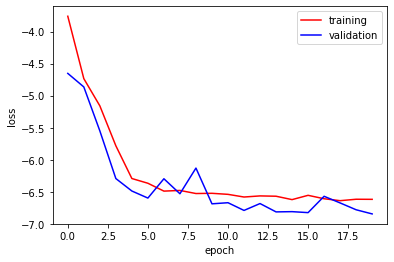

CA


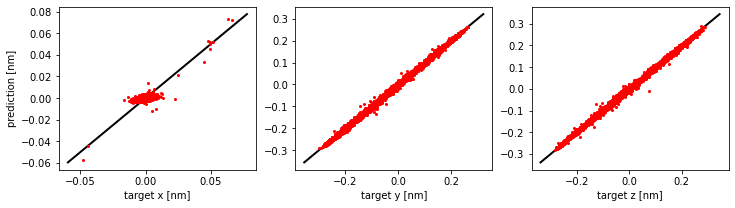

x: r2 0.6184689594224688 slope 0.6594835913665821 offset -4.013516728139681e-05
y: r2 0.9991300751572281 slope 0.9994917449395011 offset 0.00022179709066645625
z: r2 0.9982804709958301 slope 0.992618567040238 offset 0.0007947350944814705
N


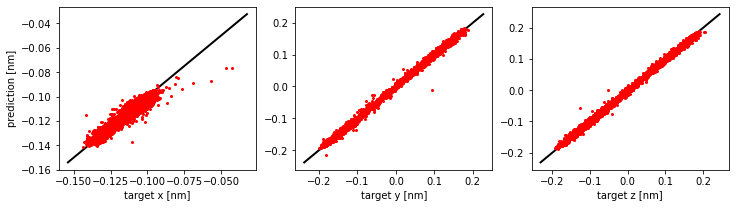

x: r2 0.932577336015127 slope 0.9186045261792162 offset -0.010071396682331535
y: r2 0.9983589133590443 slope 1.0019482384998706 offset 0.001007280408982944
z: r2 0.9974690240816064 slope 0.9899453374985949 offset 0.00014682571584724753
C


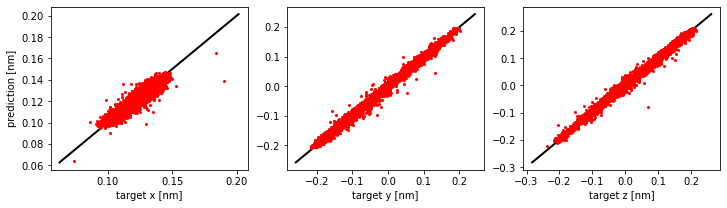

x: r2 0.8881480746137588 slope 0.8884731743081971 offset 0.01295334922369594
y: r2 0.9954696450017807 slope 0.9909041870010816 offset 0.00014340945539940975
z: r2 0.9927688863944296 slope 0.981058010157452 offset 0.0022035135905836833
O


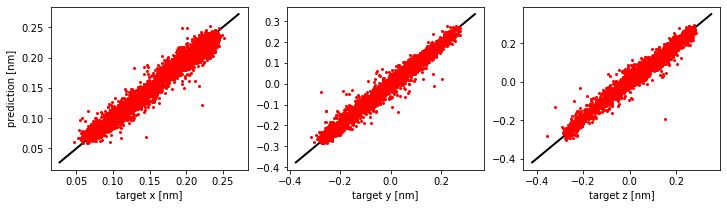

x: r2 0.9666145042002464 slope 0.9619620671758344 offset 0.004468845685850292
y: r2 0.9846982059110992 slope 0.974810521828917 offset -0.0005766597235752485
z: r2 0.9785160898203494 slope 0.9627842959952307 offset 0.005675603225274009
CB


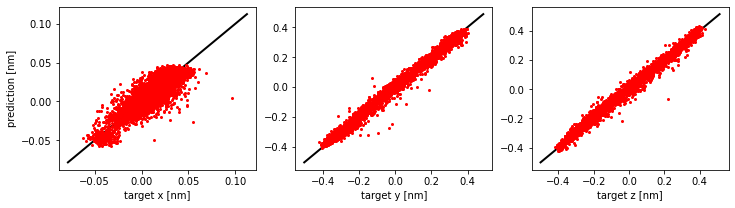

x: r2 0.8035045163769847 slope 0.9472909647164758 offset 0.0006934078762577487
y: r2 0.9939751705635221 slope 0.9930237614088439 offset 0.0006882305609153955
z: r2 0.99148800390271 slope 0.9800637562112986 offset 0.007640213420355799


In [14]:
aa='ASP'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCOCB") 

m = Model1D3_ca_n_co_cb()
m.apply(m.initialize_weights)
m.zero_grad()

# load partial weights from previous model
# may use other models previously trained 
m.load_state_dict(torch.load(f'{aa}_1d3_ca_n_co_predict_aa.dict'),strict=False)

# disable training of all weights
for param in m.parameters():
    param.requires_grad = False

# reenable training of only the second part of the network that predicts Cbetas 
# this means that the CA/N/CO prediction is not changed during training
for param in m.ccb_1.parameters():
    param.requires_grad = True
for param in m.ccb_2.parameters():
    param.requires_grad = True
for param in m.ccb_3.parameters():
    param.requires_grad = True
for param in m.ccb_4.parameters():
    param.requires_grad = True
for param in m.ccb_f.parameters():
    param.requires_grad = True   
for param in m.fccb_1.parameters():
    param.requires_grad = True
for param in m.fccb_2.parameters():
    param.requires_grad = True
for param in m.fccb_f.parameters():
    param.requires_grad = True

# optimizer with extra options to only train certain weights
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0005, weight_decay=0.00001)

epochs=20
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=3.0,klindex=12)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

print('CB')
plot_validation(vxyzloader,m,4)
linear_regression(vxyzloader,m,4)


torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_cb_predict_aa.dict")


(22729, 15)
0 0.012034641423573097 0.009773271228391698
1 0.00827341648336086 0.006438742341331285
2 0.004051730592942072 0.001991644913406043
3 0.0017461137257568124 0.001692615680624713
4 0.0016175275183438014 0.0015967695131335283
5 0.0015072526487832267 0.0014472746671810048
6 0.0014252619843723045 0.0014830996265677607
7 0.001387607054008792 0.0012725399547926558
8 0.0013951562771884103 0.0014161662593237807
9 0.001365157820853508 0.0017387307611000508
10 0.0013639699641822113 0.001297279432251729
11 0.001340833706005166 0.0013299673024304488
12 0.0013627116665399324 0.00125271629188512
13 0.001286432460700679 0.0012759406883348472
14 0.0013108920377110029 0.0014559963485754322
15 0.0013194488290335154 0.0014643072451087059
16 0.0013062749769435162 0.0015123776878891498
17 0.0013107993937511411 0.0012264821065890877
18 0.0012909509112230605 0.0015253071178901565
19 0.0013293505342315054 0.0012077439928675025


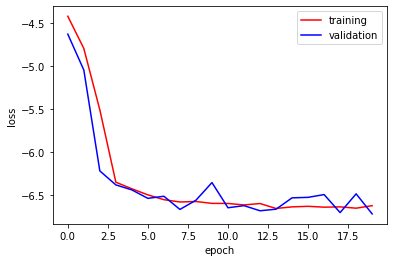

CA


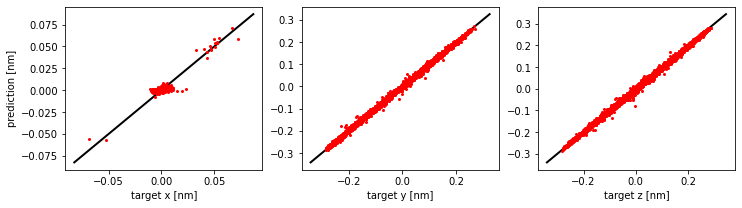

x: r2 0.7552819961780715 slope 0.7718809728142649 offset 0.0002864192612810181
y: r2 0.9990540448040308 slope 0.9961553810863012 offset -0.0004014800764898796
z: r2 0.9981055222044583 slope 0.9896343668066357 offset -0.0006370464733169753
N


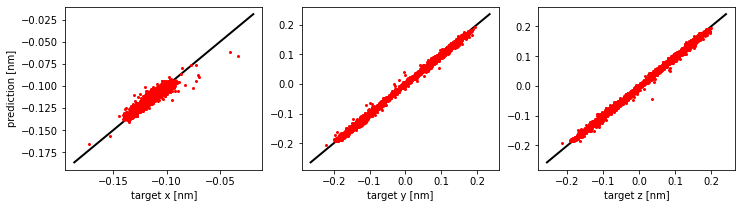

x: r2 0.9273738170650553 slope 0.9017823945088481 offset -0.010851844882845421
y: r2 0.9981776155430232 slope 0.9935322392823166 offset -0.00135177370809203
z: r2 0.9972416995921062 slope 0.9901562647011585 offset -0.0014954494136939474
C


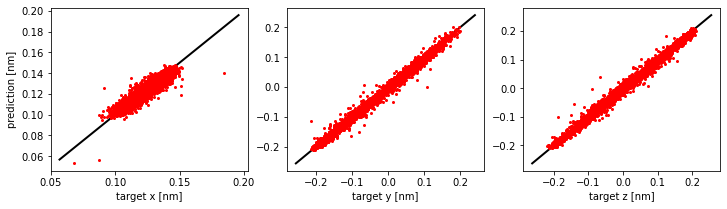

x: r2 0.8733129937701412 slope 0.8702750006932444 offset 0.015600874969681086
y: r2 0.9944392667554853 slope 0.9896633891984292 offset -0.0023397329757568405
z: r2 0.9913428838511354 slope 0.9881084907963833 offset -0.0012309217396311127
O


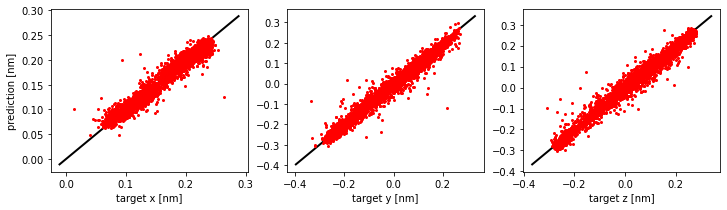

x: r2 0.958889626767268 slope 0.9467154701352765 offset 0.007852132976189585
y: r2 0.9804755122260775 slope 0.9776369491481062 offset -0.005980519006336532
z: r2 0.9764432278773114 slope 0.9756645058009141 offset -0.003048990732290008
CB


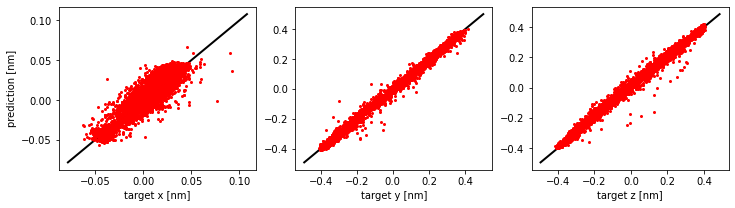

x: r2 0.8305857003709781 slope 0.9789211109468655 offset 0.001697294215320954
y: r2 0.9948668838941281 slope 0.9959748928284754 offset -0.002661608062556886
z: r2 0.98976086167201 slope 0.9805337117310255 offset 0.011417983199437955


In [15]:
aa='ASN'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCOCB") 

m = Model1D3_ca_n_co_cb()
m.apply(m.initialize_weights)
m.zero_grad()

# load partial weights from previous model
# may use other models previously trained 
m.load_state_dict(torch.load(f'{aa}_1d3_ca_n_co_predict_aa.dict'),strict=False)

# disable training of all weights
for param in m.parameters():
    param.requires_grad = False

# reenable training of only the second part of the network that predicts Cbetas 
# this means that the CA/N/CO prediction is not changed during training
for param in m.ccb_1.parameters():
    param.requires_grad = True
for param in m.ccb_2.parameters():
    param.requires_grad = True
for param in m.ccb_3.parameters():
    param.requires_grad = True
for param in m.ccb_4.parameters():
    param.requires_grad = True
for param in m.ccb_f.parameters():
    param.requires_grad = True   
for param in m.fccb_1.parameters():
    param.requires_grad = True
for param in m.fccb_2.parameters():
    param.requires_grad = True
for param in m.fccb_f.parameters():
    param.requires_grad = True

# optimizer with extra options to only train certain weights
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0005, weight_decay=0.00001)

epochs=20
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=3.0,klindex=12)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

print('CB')
plot_validation(vxyzloader,m,4)
linear_regression(vxyzloader,m,4)


torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_cb_predict_aa.dict")


(32362, 15)
0 0.014058468689886378 0.007688499216737291
1 0.006273451297744817 0.004880836976811284
2 0.003998208434923607 0.003503714551906048
3 0.002744930563494563 0.0018124439422737742
4 0.0018221813975376827 0.0014422670514912224
5 0.0015526925231896195 0.0020270617140462034
6 0.0014776243673016627 0.0010884095336341298
7 0.0014150772670594354 0.001087172023945316
8 0.0013513022282745177 0.001349187927477433
9 0.001365912162844895 0.0014379971419093164
10 0.0013305288636783028 0.0010234946437647947
11 0.001301151775645421 0.001690041905878722
12 0.001325154378005833 0.0012843329825194055
13 0.001328472835559617 0.0018297171610498252
14 0.0012945301098036854 0.0012446774727433653
15 0.001304256265261667 0.0010713238244060435
16 0.0012639733910213644 0.001269550746085762
17 0.0012558258878176704 0.0012449424592394255
18 0.0012640308077428856 0.0016317050514644798
19 0.001250991321570587 0.001887772937220492


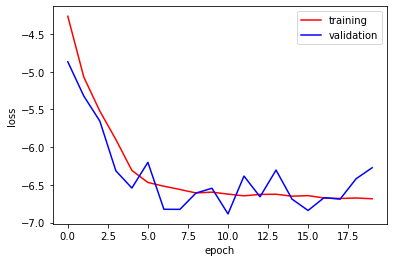

CA


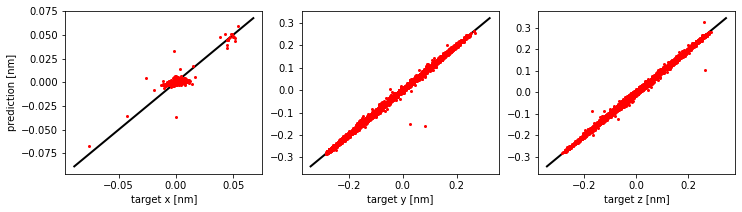

x: r2 0.6723829125344184 slope 0.6895181367777858 offset -8.199027044025757e-05
y: r2 0.9987194619603001 slope 1.0011153378168838 offset 0.0007557484814489646
z: r2 0.9976197975617728 slope 0.9955606087942843 offset 0.00021132671163467866
N


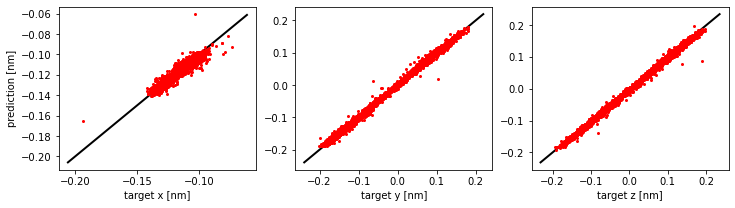

x: r2 0.938308825682415 slope 0.9416573197521694 offset -0.007168577405024842
y: r2 0.9982555141191666 slope 0.9982958639875897 offset 0.0010849562823359582
z: r2 0.9973982179920242 slope 0.995642732300339 offset -0.0020969701795362835
C


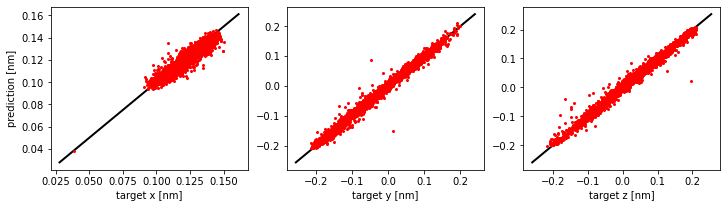

x: r2 0.8675406248607445 slope 0.8822683503723023 offset 0.013051826536778388
y: r2 0.9954261987040213 slope 0.9972852089921593 offset 0.001499723965289218
z: r2 0.9899391151124911 slope 0.9845831929851471 offset 0.00104842247095795
O


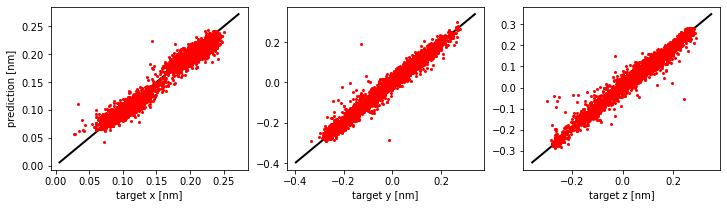

x: r2 0.9657367165077722 slope 0.9656362988539401 offset 0.0027910814017378383
y: r2 0.9860357017223828 slope 0.9890329731948204 offset 0.0018038587416385476
z: r2 0.9722894054288964 slope 0.963673470605885 offset 0.005094966250370758
CB


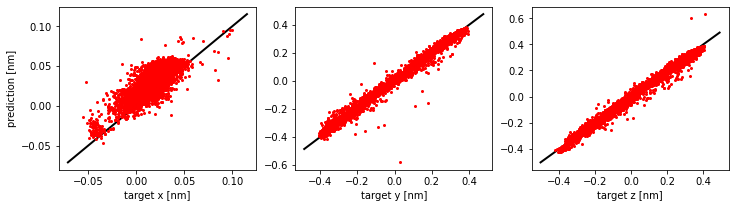

x: r2 0.6999579470461333 slope 0.9428500685723166 offset 0.015877303160491178
y: r2 0.9919432187873266 slope 0.9874344227223109 offset 0.007376975942609637
z: r2 0.9892533748263376 slope 0.9933218886305515 offset -0.004703926645385964


In [16]:
aa='GLU'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCOCB") 

m = Model1D3_ca_n_co_cb()
m.apply(m.initialize_weights)
m.zero_grad()

# load partial weights from previous model
# may use other models previously trained 
m.load_state_dict(torch.load(f'{aa}_1d3_ca_n_co_predict_aa.dict'),strict=False)

# disable training of all weights
for param in m.parameters():
    param.requires_grad = False

# reenable training of only the second part of the network that predicts Cbetas 
# this means that the CA/N/CO prediction is not changed during training
for param in m.ccb_1.parameters():
    param.requires_grad = True
for param in m.ccb_2.parameters():
    param.requires_grad = True
for param in m.ccb_3.parameters():
    param.requires_grad = True
for param in m.ccb_4.parameters():
    param.requires_grad = True
for param in m.ccb_f.parameters():
    param.requires_grad = True   
for param in m.fccb_1.parameters():
    param.requires_grad = True
for param in m.fccb_2.parameters():
    param.requires_grad = True
for param in m.fccb_f.parameters():
    param.requires_grad = True

# optimizer with extra options to only train certain weights
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0005, weight_decay=0.00001)

epochs=20
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=3.0,klindex=12)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

print('CB')
plot_validation(vxyzloader,m,4)
linear_regression(vxyzloader,m,4)


torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_cb_predict_aa.dict")


(18856, 15)
0 0.01302295442049702 0.008833598993381264
1 0.007577842784424623 0.005915129143994517
2 0.004042095652160545 0.0023392646171089336
3 0.0021860664205936094 0.0021757442524961246
4 0.001699871232267469 0.0014249019834286594
5 0.0015035008545964956 0.0012615385411726685
6 0.001416459547666212 0.0016414515432279803
7 0.001343969729108115 0.0018728988906933017
8 0.0013840035574200253 0.0012597844315260986
9 0.0013036482540580133 0.0014782840910868662
10 0.001337130239699036 0.0012535069087872177
11 0.0012810852184581259 0.0011604915654589132
12 0.0012244846943455438 0.0014267037713855014
13 0.0012420544517226517 0.0012976843240291283
14 0.0012412041697340706 0.00112276607922878
15 0.0012223282072227448 0.0016775780100676191
16 0.0012708687650350233 0.0011008632760811455
17 0.0012309442759336283 0.001049214893857793
18 0.0012089275599767764 0.0015835591951358962
19 0.0012444121103423337 0.001340340609710089


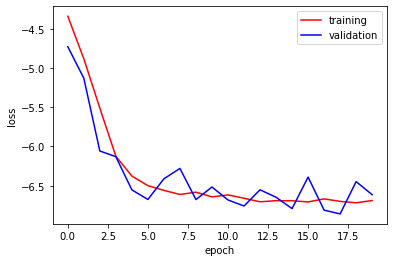

CA


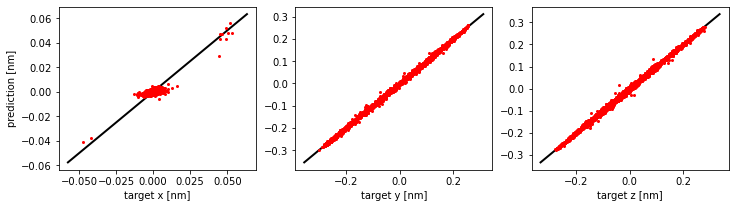

x: r2 0.7156207619464323 slope 0.6704769462412471 offset -0.00013208189310440186
y: r2 0.9993934552736069 slope 0.9990317834616511 offset -0.0004275974217387013
z: r2 0.9979114249884475 slope 0.9990233914838805 offset -0.00030365551897465265
N


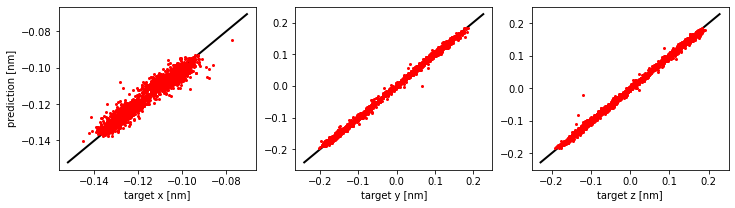

x: r2 0.9371907401610464 slope 0.9212190901476875 offset -0.008611548041690884
y: r2 0.9985287024408255 slope 0.997937898963428 offset 0.0007022005795246089
z: r2 0.9969130011644576 slope 0.9990909241585424 offset -0.0012682526684320676
C


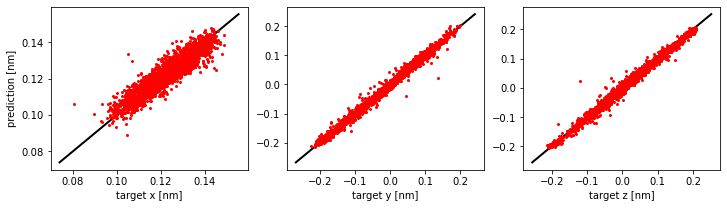

x: r2 0.8534735029663836 slope 0.8608548073495161 offset 0.016990240300481435
y: r2 0.9956602230557882 slope 1.0012382115078975 offset 0.001092677808224779
z: r2 0.9898802131761156 slope 0.9951149346337663 offset -0.0010480923860049403
O


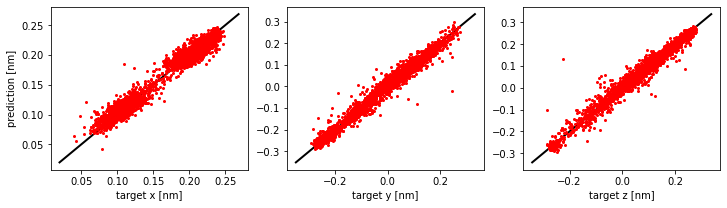

x: r2 0.9634804272964854 slope 0.9450137858544747 offset 0.009989995490934767
y: r2 0.9853856601530507 slope 0.9886983343740393 offset 0.00021399068155568413
z: r2 0.9698953701198132 slope 0.9747136010568566 offset 0.0025374697404495217
CB


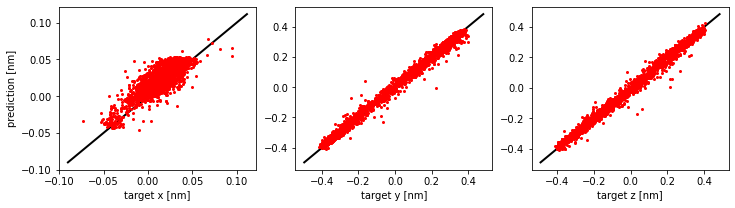

x: r2 0.7515164378816644 slope 0.9059607461242094 offset 0.011611066031747299
y: r2 0.9948785745447859 slope 0.9894751861118289 offset 0.00484822195450621
z: r2 0.9899595773328003 slope 0.9887001381721289 offset -0.004345683684584108


In [17]:
aa='GLN'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCOCB") 

m = Model1D3_ca_n_co_cb()
m.apply(m.initialize_weights)
m.zero_grad()

# load partial weights from previous model
# may use other models previously trained 
m.load_state_dict(torch.load(f'{aa}_1d3_ca_n_co_predict_aa.dict'),strict=False)

# disable training of all weights
for param in m.parameters():
    param.requires_grad = False

# reenable training of only the second part of the network that predicts Cbetas 
# this means that the CA/N/CO prediction is not changed during training
for param in m.ccb_1.parameters():
    param.requires_grad = True
for param in m.ccb_2.parameters():
    param.requires_grad = True
for param in m.ccb_3.parameters():
    param.requires_grad = True
for param in m.ccb_4.parameters():
    param.requires_grad = True
for param in m.ccb_f.parameters():
    param.requires_grad = True   
for param in m.fccb_1.parameters():
    param.requires_grad = True
for param in m.fccb_2.parameters():
    param.requires_grad = True
for param in m.fccb_f.parameters():
    param.requires_grad = True

# optimizer with extra options to only train certain weights
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0005, weight_decay=0.00001)

epochs=20
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=3.0,klindex=12)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

print('CB')
plot_validation(vxyzloader,m,4)
linear_regression(vxyzloader,m,4)


torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_cb_predict_aa.dict")


(18999, 15)
0 0.013980322455366453 0.008850303330223602
1 0.008297769663234552 0.007177413541016594
2 0.00554129269439727 0.003823828717966446
3 0.002913947923419376 0.0022541304540574856
4 0.0020662069863950213 0.0023816135912383325
5 0.001787445954202364 0.0019389644475411544
6 0.0015824519097805024 0.001587838237260711
7 0.0014267812133766712 0.001770336579258193
8 0.00143410194820414 0.0013824207674794857
9 0.0013549963477998972 0.001262975413608838
10 0.001355769574486961 0.0012262791415962354
11 0.0013038712670095265 0.0018280877678413777
12 0.0013266479092029235 0.00125684618829223
13 0.0012627527117729186 0.0013849944051863357
14 0.0014169765636324883 0.001293145985553835
15 0.0013365511355611186 0.0012179183485340876
16 0.001250746128304551 0.001397032349841306
17 0.0012350912981977066 0.0012995680125092756
18 0.001250155821132163 0.0011410788567012865
19 0.0012709561580171189 0.0012742309188648706


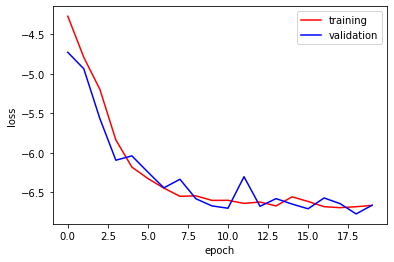

CA


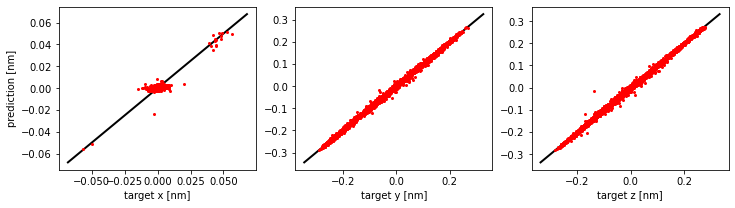

x: r2 0.7733099378866286 slope 0.7682628317771741 offset 0.00040091892289504706
y: r2 0.9991341703812415 slope 1.000052086297879 offset 0.0006767891851500521
z: r2 0.9973249990978678 slope 1.0010738631384126 offset 0.0005205195129772827
N


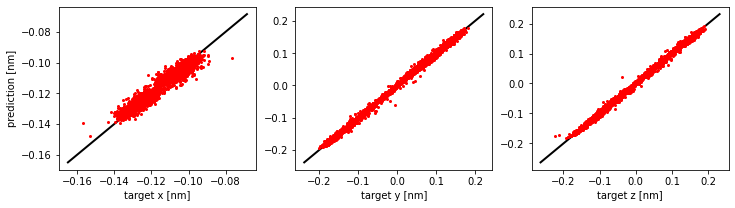

x: r2 0.9343405017330774 slope 0.9291384191510863 offset -0.008291930146366908
y: r2 0.9980807531889238 slope 0.9998943412501415 offset 0.0004157970697409863
z: r2 0.99657079430913 slope 0.9961883286275235 offset 0.0016677067138049367
C


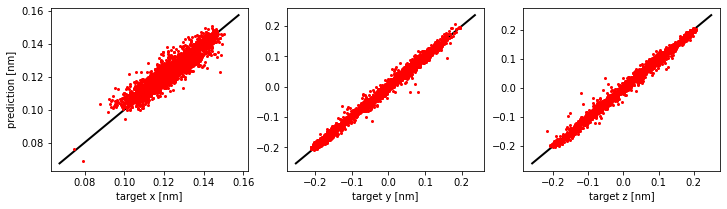

x: r2 0.849489942526846 slope 0.8634877261680056 offset 0.017409309386545627
y: r2 0.9941786415062608 slope 0.9970256368134853 offset 0.001383815961960723
z: r2 0.9877734641407223 slope 0.9944038538118007 offset -0.0007695431831667501
O


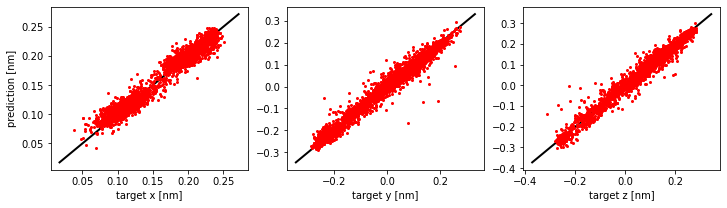

x: r2 0.9604737035121599 slope 0.9592631632435417 offset 0.007607997620374424
y: r2 0.9788145627854288 slope 0.9790708899699504 offset 0.0002669597924153458
z: r2 0.9686070149973715 slope 0.9798548715792881 offset 0.00024140790521025302
CB


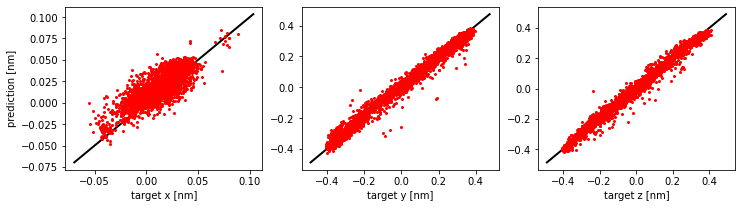

x: r2 0.6965950468132702 slope 0.7979087022701674 offset 0.009146446583103242
y: r2 0.9907577700148216 slope 0.9958309468521687 offset 0.00463299649421095
z: r2 0.9844764296414478 slope 0.9826063340265729 offset 0.002575705767718227


In [18]:
aa='TYR'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCOCB") 

m = Model1D3_ca_n_co_cb()
m.apply(m.initialize_weights)
m.zero_grad()

# load partial weights from previous model
# may use other models previously trained 
m.load_state_dict(torch.load(f'{aa}_1d3_ca_n_co_predict_aa.dict'),strict=False)

# disable training of all weights
for param in m.parameters():
    param.requires_grad = False

# reenable training of only the second part of the network that predicts Cbetas 
# this means that the CA/N/CO prediction is not changed during training
for param in m.ccb_1.parameters():
    param.requires_grad = True
for param in m.ccb_2.parameters():
    param.requires_grad = True
for param in m.ccb_3.parameters():
    param.requires_grad = True
for param in m.ccb_4.parameters():
    param.requires_grad = True
for param in m.ccb_f.parameters():
    param.requires_grad = True   
for param in m.fccb_1.parameters():
    param.requires_grad = True
for param in m.fccb_2.parameters():
    param.requires_grad = True
for param in m.fccb_f.parameters():
    param.requires_grad = True

# optimizer with extra options to only train certain weights
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0005, weight_decay=0.00001)

epochs=20
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=2.0,klindex=12)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

print('CB')
plot_validation(vxyzloader,m,4)
linear_regression(vxyzloader,m,4)


torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_cb_predict_aa.dict")


(6732, 15)
0 0.018313626081428745 0.009599917945016126
1 0.009675443934446032 0.008807865432622727
2 0.008812257258052176 0.008148263384661406
3 0.00781283506446264 0.007276382302639821
4 0.006769197738983415 0.005862989352118601
5 0.005522680934518576 0.004638913138451501
6 0.004643839783966541 0.004058455937770528
7 0.00416130352426659 0.00392491882804248
8 0.0038753758946602993 0.0033162586535691258
9 0.0033723343671722846 0.0030469930851889115
10 0.0030930682974444194 0.0027018649889376596
11 0.0026336772028695454 0.0020329640263860825
12 0.002188404418782077 0.0019547874539919572
13 0.002035344315862114 0.0015811132464398118
14 0.0018434208415617998 0.0017824916147565443
15 0.0017675728515975854 0.0014873170361235062
16 0.0017621329752728343 0.0020933060764124624
17 0.0016953970136290247 0.0014637902718973447
18 0.0015403888167136095 0.0014531626997738465
19 0.0015149116939441724 0.0014442233233113995
20 0.0015482714886523106 0.0015292670716769898
21 0.0016291541555388408 0.001303

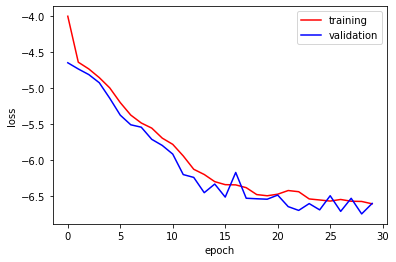

CA


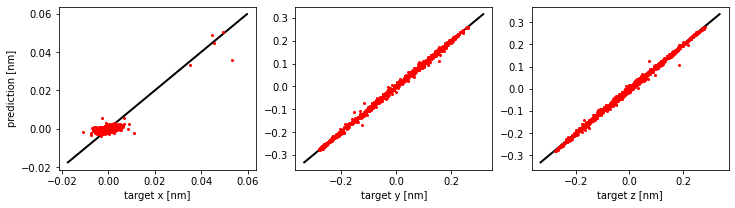

x: r2 0.7221445785247438 slope 0.6853657231605614 offset 4.1197632536731786e-05
y: r2 0.9989306539266829 slope 0.9984999187741801 offset 0.0005157504874476679
z: r2 0.9970381103055787 slope 0.9970770074539855 offset 0.0002751023631177574
N


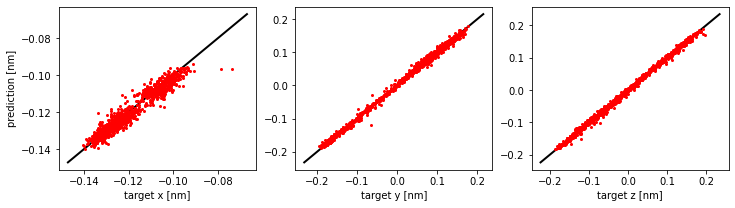

x: r2 0.934344875001948 slope 0.9317864982143887 offset -0.008372084367609264
y: r2 0.997867308996813 slope 0.9970713601465668 offset 0.001499118554841479
z: r2 0.9965694474846232 slope 1.003201781129505 offset 6.543850588711618e-05
C


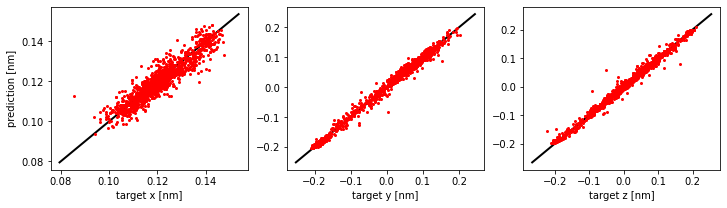

x: r2 0.8567106433392258 slope 0.8960122041986771 offset 0.01225148570129099
y: r2 0.9933479749609363 slope 0.9938617082691308 offset 0.0007273373246193537
z: r2 0.9864194417565236 slope 0.9826795358851452 offset 0.001297298358032526
O


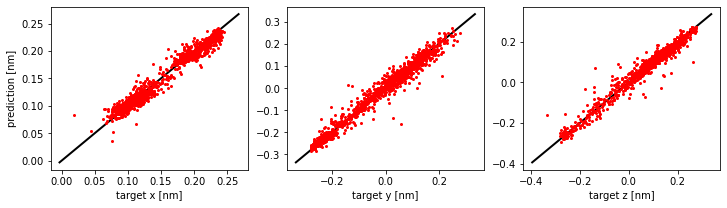

x: r2 0.963493688520433 slope 0.9425287997868135 offset 0.00799717002988451
y: r2 0.9751541872038311 slope 0.9770392320876183 offset 0.001378639519844356
z: r2 0.9625324027223104 slope 0.9630364342141272 offset 0.004410343801638156
CB


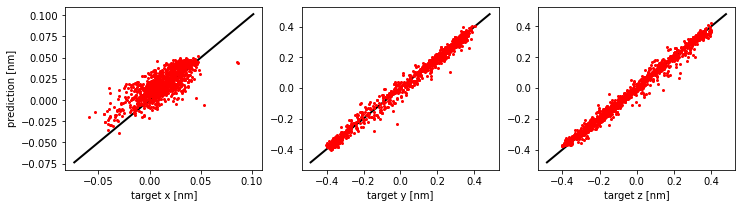

x: r2 0.6492053179019674 slope 0.7385337140044894 offset 0.010828180298611973
y: r2 0.9918649940382809 slope 0.9956389167495804 offset -0.004846278084504881
z: r2 0.9833847165435007 slope 0.9765067481691563 offset 0.0003388648717149653


In [19]:
aa='CYS'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCOCB") 

m = Model1D3_ca_n_co_cb()
m.apply(m.initialize_weights)
m.zero_grad()

# load partial weights from previous model
# may use other models previously trained 
m.load_state_dict(torch.load(f'{aa}_1d3_ca_n_co_predict_aa.dict'),strict=False)

# disable training of all weights
for param in m.parameters():
    param.requires_grad = False

# reenable training of only the second part of the network that predicts Cbetas 
# this means that the CA/N/CO prediction is not changed during training
for param in m.ccb_1.parameters():
    param.requires_grad = True
for param in m.ccb_2.parameters():
    param.requires_grad = True
for param in m.ccb_3.parameters():
    param.requires_grad = True
for param in m.ccb_4.parameters():
    param.requires_grad = True
for param in m.ccb_f.parameters():
    param.requires_grad = True   
for param in m.fccb_1.parameters():
    param.requires_grad = True
for param in m.fccb_2.parameters():
    param.requires_grad = True
for param in m.fccb_f.parameters():
    param.requires_grad = True

# optimizer with extra options to only train certain weights
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0005, weight_decay=0.00001)

epochs=30
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=2.0,klindex=12)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

print('CB')
plot_validation(vxyzloader,m,4)
linear_regression(vxyzloader,m,4)


torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_cb_predict_aa.dict")


(11755, 15)
0 0.01747005653420561 0.01023824895712892
1 0.008444894350280887 0.0073810355374942125
2 0.006192638514269339 0.005120640226579594
3 0.004343926722772028 0.004172067584844315
4 0.003483882149387347 0.0030282598460106857
5 0.0027058934425248913 0.002368139349506014
6 0.0021387199920259023 0.001870838201535323
7 0.0018072310822868818 0.0017917187975880675
8 0.0017171817231237103 0.002112845625799711
9 0.0016497396925268205 0.002014464290475163
10 0.0016199836544202346 0.0016840598574665393
11 0.0015256231540421907 0.0015921089132350517
12 0.0014865664752984518 0.0015846227345048525
13 0.0014728684419471967 0.0014480207581700523
14 0.0014788214680983831 0.0014191554891070733
15 0.0014424832402973582 0.001430905795192625
16 0.0013771784234497893 0.001709058001873539
17 0.0014123134560098773 0.0013729257527626436
18 0.0014294630933651014 0.0016512317503325502
19 0.0013838897483717453 0.001455741560206706


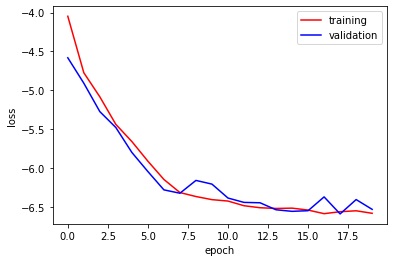

CA


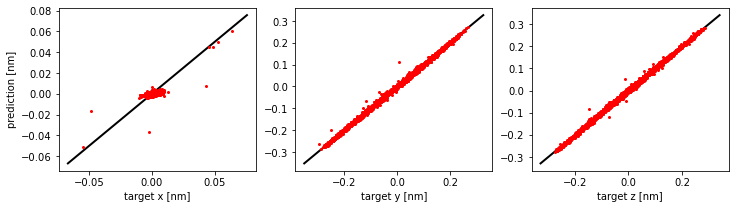

x: r2 0.616173956778084 slope 0.6034940874496493 offset -0.00022440675481221788
y: r2 0.9989413460877055 slope 0.9986911346591824 offset 0.0002129991035453721
z: r2 0.9978836324995389 slope 1.0051622810632983 offset 0.0004523651197579411
N


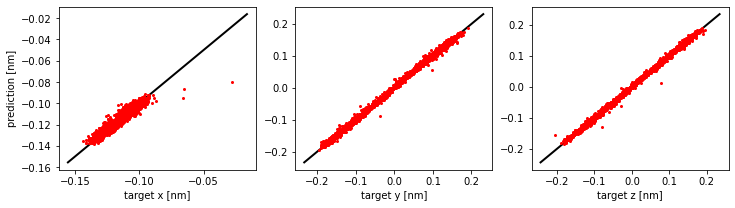

x: r2 0.9272705635342697 slope 0.9173125639068231 offset -0.008971358693657769
y: r2 0.9980121817475637 slope 0.9979262500054539 offset 0.0017907751002439742
z: r2 0.996738572572554 slope 0.9990971729370031 offset 0.0009968352587915365
C


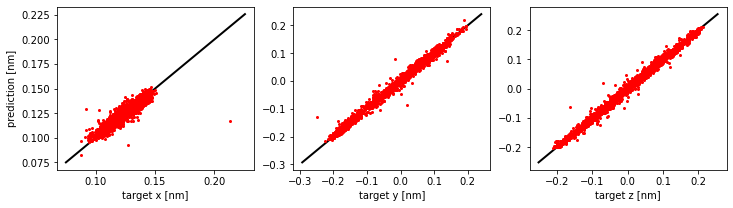

x: r2 0.8335471380383042 slope 0.8581947521227271 offset 0.01819893234131062
y: r2 0.9935310430730235 slope 0.9963694504801568 offset 0.0019704885312164314
z: r2 0.9897719387377358 slope 0.999984108130814 offset 0.0005317613563532511
O


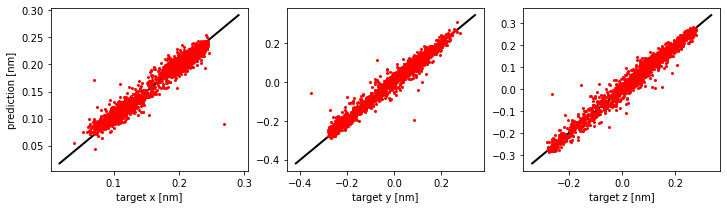

x: r2 0.9557378179682076 slope 0.9400678726669335 offset 0.010993286368749355
y: r2 0.978356533598008 slope 0.9806260970616046 offset 0.004004589589539587
z: r2 0.9730675469933706 slope 0.9851851205041267 offset 0.0011367445188050634
CB


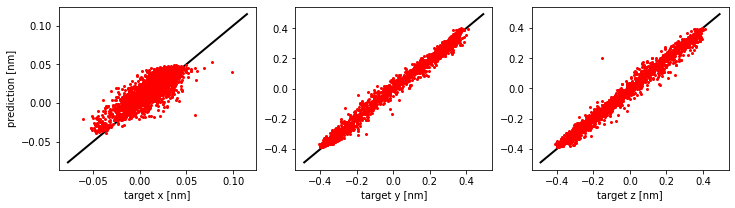

x: r2 0.7048534131793414 slope 0.7859802161967306 offset 0.007827703499979844
y: r2 0.9910517360124793 slope 0.9849989166511952 offset -0.0015825919438627184
z: r2 0.9808115327888179 slope 0.9703923439435994 offset -0.003828631556165085


In [20]:
aa='HIS'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCOCB") 

m = Model1D3_ca_n_co_cb()
m.apply(m.initialize_weights)
m.zero_grad()

# load partial weights from previous model
# may use other models previously trained 
m.load_state_dict(torch.load(f'{aa}_1d3_ca_n_co_predict_aa.dict'),strict=False)

# disable training of all weights
for param in m.parameters():
    param.requires_grad = False

# reenable training of only the second part of the network that predicts Cbetas 
# this means that the CA/N/CO prediction is not changed during training
for param in m.ccb_1.parameters():
    param.requires_grad = True
for param in m.ccb_2.parameters():
    param.requires_grad = True
for param in m.ccb_3.parameters():
    param.requires_grad = True
for param in m.ccb_4.parameters():
    param.requires_grad = True
for param in m.ccb_f.parameters():
    param.requires_grad = True   
for param in m.fccb_1.parameters():
    param.requires_grad = True
for param in m.fccb_2.parameters():
    param.requires_grad = True
for param in m.fccb_f.parameters():
    param.requires_grad = True

# optimizer with extra options to only train certain weights
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0005, weight_decay=0.00001)

epochs=20
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=2.0,klindex=12)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

print('CB')
plot_validation(vxyzloader,m,4)
linear_regression(vxyzloader,m,4)


torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_cb_predict_aa.dict")


(28815, 15)
0 0.015223335373498823 0.00798197119456887
1 0.0067085710799564486 0.005101926511137176
2 0.0036400672574730024 0.003545536791447099
3 0.002334315018505668 0.002250580955730781
4 0.0017868926262725954 0.0013722447042972736
5 0.0013839908060617745 0.0015685227397820628
6 0.0012602860755894494 0.0017439863893512393
7 0.0012736577178736259 0.0011346263781639061
8 0.0011509066769023143 0.0012895537416352596
9 0.001133859416965962 0.0011840224347752426
10 0.0011309961871871644 0.0016065018201961267
11 0.0011287953479357225 0.0010872291407469428
12 0.001132634174807564 0.001217928171471924
13 0.0011175649187466859 0.0018583901716315077
14 0.001111604226500039 0.0009474211971911095
15 0.0011263544273906914 0.0017616089443395508
16 0.0012774067214669903 0.0009369308779307817
17 0.0010693592067463728 0.0009324038966547608
18 0.0011021611280739307 0.0010299900259651549
19 0.0010615450357917048 0.001368392076554322


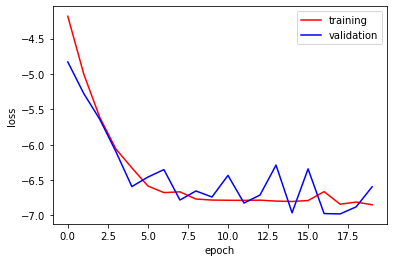

CA


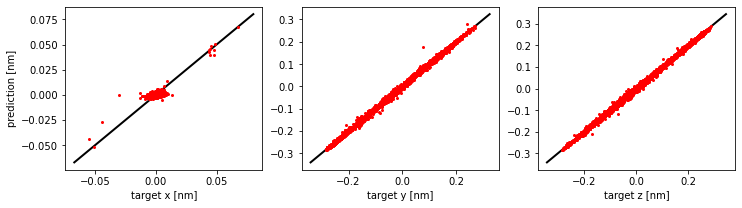

x: r2 0.6488146869766744 slope 0.619024133626449 offset -8.443072318254296e-05
y: r2 0.9992440709475013 slope 1.0048757448785577 offset 0.0007676538036342773
z: r2 0.9983267430973046 slope 1.0012609271019663 offset -0.00019646043953287524
N


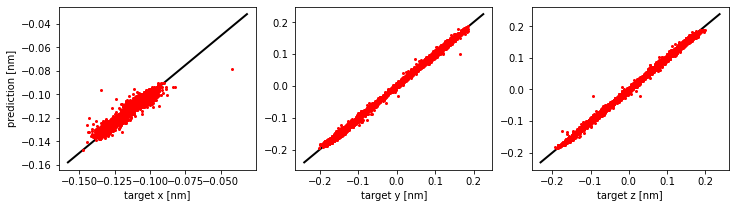

x: r2 0.9357010999937985 slope 0.9375398465921139 offset -0.0062111122945019
y: r2 0.998556844940438 slope 1.0018137893203942 offset 4.573323922223149e-05
z: r2 0.9976346815471946 slope 1.0011304761568092 offset -0.0002808662418143752
C


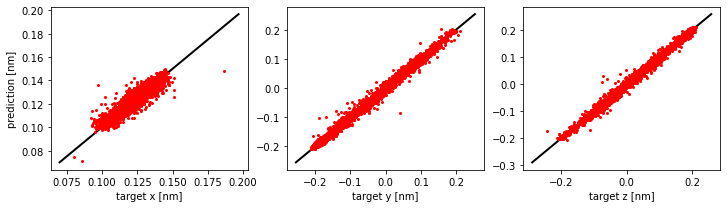

x: r2 0.8557595628472492 slope 0.8826627534097058 offset 0.015343977367979753
y: r2 0.995544237486073 slope 1.0036042672217707 offset 0.0007742457885186182
z: r2 0.9917000710754722 slope 1.0021737615580086 offset -0.00030470448285487006
O


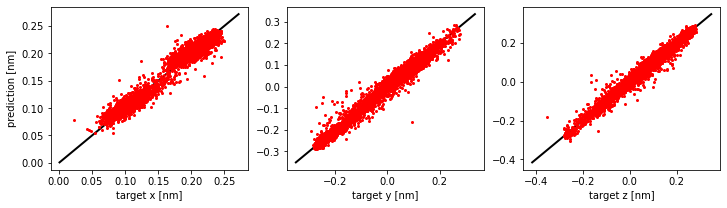

x: r2 0.9637477446133733 slope 0.9753159203034806 offset 0.005600520410769805
y: r2 0.9851698123840386 slope 0.9866974902915782 offset -0.0030061849306766697
z: r2 0.9753183009618887 slope 0.9865983363332388 offset 0.0011478700615385473
CB


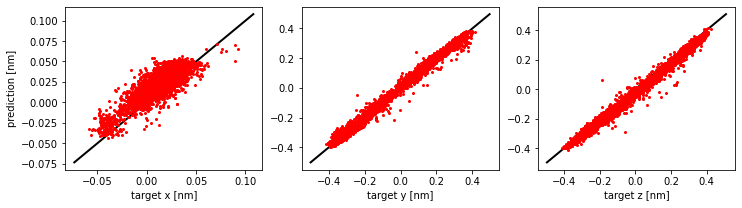

x: r2 0.778909892704964 slope 0.8673509880748601 offset 0.01275967103661649
y: r2 0.9947602404803132 slope 1.0009194676675401 offset 0.0019289150081023831
z: r2 0.9909656052170546 slope 0.9837819678194872 offset -0.02071428762280663


In [21]:
aa='LYS'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCOCB") 

m = Model1D3_ca_n_co_cb()
m.apply(m.initialize_weights)
m.zero_grad()

# load partial weights from previous model
# may use other models previously trained 
#m.load_state_dict(torch.load(f"{aa}_1d3_ca_n_co_cb_predict_aa.dict"))
m.load_state_dict(torch.load(f'{aa}_1d3_ca_n_co_predict_aa.dict'),strict=False)

# disable training of all weights
for param in m.parameters():
    param.requires_grad = False

# reenable training of only the second part of the network that predicts Cbetas 
# this means that the CA/N/CO prediction is not changed during training
for param in m.ccb_1.parameters():
    param.requires_grad = True
for param in m.ccb_2.parameters():
    param.requires_grad = True
for param in m.ccb_3.parameters():
    param.requires_grad = True
for param in m.ccb_4.parameters():
    param.requires_grad = True
for param in m.ccb_f.parameters():
    param.requires_grad = True   
for param in m.fccb_1.parameters():
    param.requires_grad = True
for param in m.fccb_2.parameters():
    param.requires_grad = True
for param in m.fccb_f.parameters():
    param.requires_grad = True

# optimizer with extra options to only train certain weights
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0005, weight_decay=0.00001)


epochs=20
#epochs=5
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=2.0,klindex=12)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

print('CB')
plot_validation(vxyzloader,m,4)
linear_regression(vxyzloader,m,4)


torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_cb_predict_aa.dict")


(10265, 15)
0 0.020698060172007364 0.010056235619511725
1 0.009309427374426056 0.00837253836932589
2 0.007798890199731378 0.006615391030478488
3 0.005637851666987818 0.004426820719053473
4 0.0037526424481149983 0.0034019550840243963
5 0.00297576909446541 0.0034173644737956212
6 0.0025695989606902003 0.0021994932964972368
7 0.001981779439922641 0.0015754655900760426
8 0.0016624494729673162 0.0018503296606599785
9 0.0016278205987285165 0.0020183832485368156
10 0.0015800784629605273 0.0014730930968288372
11 0.0016191266511347802 0.0013495606946267024
12 0.001466876597773722 0.0013678802300402322
13 0.0015387731083833119 0.0012935433280084011
14 0.001427042859551661 0.001312046441621761
15 0.0013825679197907448 0.001352090955591559
16 0.0013386218548368882 0.0014658347625710164
17 0.0013695091817199306 0.0016013188241153133
18 0.0014008025583975455 0.00116975915127399
19 0.0013449351536110044 0.0011743191358796876


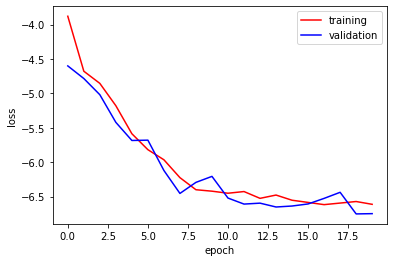

CA


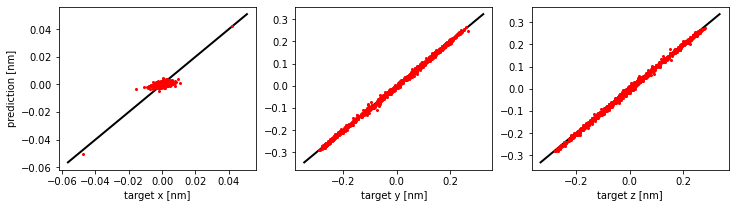

x: r2 0.5074577710711916 slope 0.5013757451685057 offset 6.411214642054194e-05
y: r2 0.9993881289852079 slope 1.0026741331845515 offset -0.00020816353111692554
z: r2 0.997677901601025 slope 1.0072089973480043 offset -0.001387153172854023
N


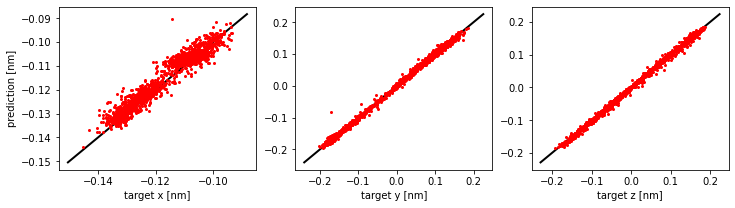

x: r2 0.9351802362719218 slope 0.9185320219763657 offset -0.007893261156735401
y: r2 0.9981987036309655 slope 1.0047323240151147 offset 0.0008161594545108147
z: r2 0.9967746235622796 slope 1.0053795552572808 offset 0.000275361685453477
C


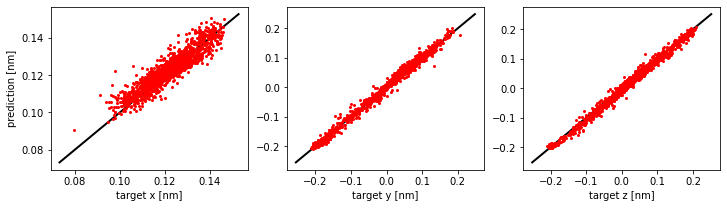

x: r2 0.8342776917086647 slope 0.8485924429866614 offset 0.019540783337152534
y: r2 0.9956731364470662 slope 1.0158979794533087 offset 0.002906479616484714
z: r2 0.9896091841063328 slope 1.0108804015996393 offset -0.0019100591084169338
O


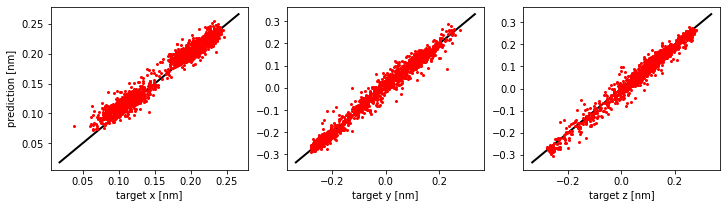

x: r2 0.9631446589017054 slope 0.9293374164977369 offset 0.01658454961624592
y: r2 0.9836761889339063 slope 1.0151006286090942 offset 0.00513524857184447
z: r2 0.9732782239374684 slope 1.0083539501457266 offset -0.004649249467399003
CB


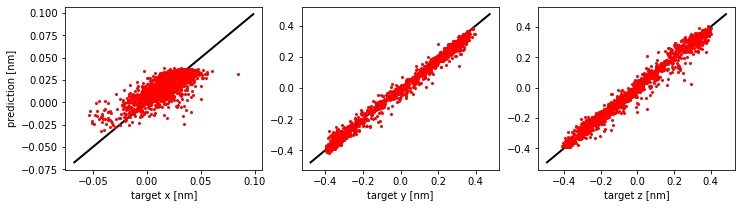

x: r2 0.6453270139875003 slope 0.6235188510354127 offset 0.00782577322220489
y: r2 0.993389688770487 slope 0.9817380791741587 offset -0.013875221451881192
z: r2 0.9736588839445679 slope 0.9640612760501974 offset 0.0014367688186631977


In [22]:
aa='MET'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCOCB") 

m = Model1D3_ca_n_co_cb()
m.apply(m.initialize_weights)
m.zero_grad()

# load partial weights from previous model
# may use other models previously trained 
m.load_state_dict(torch.load(f'{aa}_1d3_ca_n_co_predict_aa.dict'),strict=False)

# disable training of all weights
for param in m.parameters():
    param.requires_grad = False

# reenable training of only the second part of the network that predicts Cbetas 
# this means that the CA/N/CO prediction is not changed during training
for param in m.ccb_1.parameters():
    param.requires_grad = True
for param in m.ccb_2.parameters():
    param.requires_grad = True
for param in m.ccb_3.parameters():
    param.requires_grad = True
for param in m.ccb_4.parameters():
    param.requires_grad = True
for param in m.ccb_f.parameters():
    param.requires_grad = True   
for param in m.fccb_1.parameters():
    param.requires_grad = True
for param in m.fccb_2.parameters():
    param.requires_grad = True
for param in m.fccb_f.parameters():
    param.requires_grad = True

# optimizer with extra options to only train certain weights
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0005, weight_decay=0.00001)

epochs=20
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=2.0,klindex=12)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

print('CB')
plot_validation(vxyzloader,m,4)
linear_regression(vxyzloader,m,4)


torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_cb_predict_aa.dict")


(30553, 15)
0 0.012645744330560168 0.007787260278406265
1 0.0059194394561927766 0.004000495917532481
2 0.0030704018184527135 0.002244325629613687
3 0.0016821905034400213 0.0014197389490908925
4 0.0014731076444149949 0.001805997635918014
5 0.0013722003714065067 0.001381266358856906
6 0.0012885665855719708 0.001393335381984018
7 0.0012569724931381643 0.0012228693232024127
8 0.0012222128643770702 0.0011239584110925506
9 0.0012251761290826835 0.0011847028140157187
10 0.001246940058384401 0.001100027137165238
11 0.0011870622753728337 0.0011014174077329842
12 0.0011662210745271295 0.0011829028863973978
13 0.0011529667074986112 0.0012621177857999862
14 0.001132903173129307 0.0011771457405225095
15 0.001140264258234917 0.0015547338156311331
16 0.0011632822279352695 0.0010814997408650376
17 0.0011655922025965992 0.00102986395174461
18 0.0011099569661989033 0.0011004110044523139
19 0.0011207610684020135 0.001191112980469175


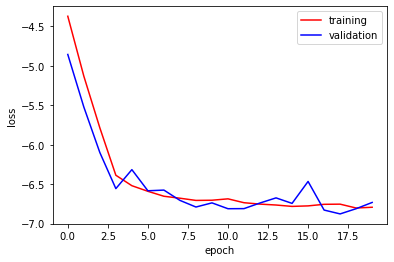

CA


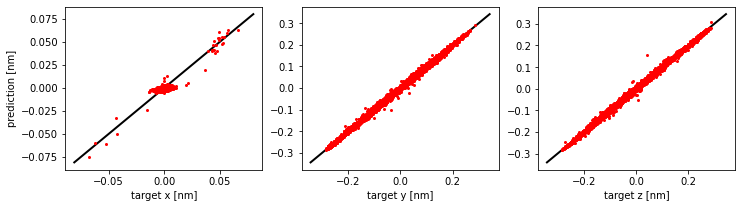

x: r2 0.7826111527555567 slope 0.8064226971182035 offset -0.0006497097679844526
y: r2 0.9989528596794408 slope 0.9986069749144233 offset 3.615638214593542e-05
z: r2 0.9978494554549497 slope 0.9988847692158777 offset 0.000538441537707008
N


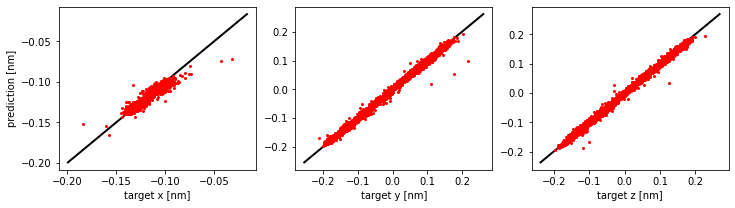

x: r2 0.9450975724218644 slope 0.9346511594542153 offset -0.008987001955297155
y: r2 0.9977747862010374 slope 0.9982154591165426 offset -4.273882605026341e-05
z: r2 0.996526976383014 slope 0.9975845930166043 offset -0.00036015117208256127
C


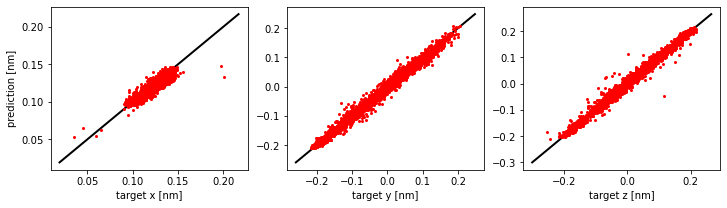

x: r2 0.8956086561648864 slope 0.8995838082064975 offset 0.010473797275680319
y: r2 0.9941886348545058 slope 0.9908382404656493 offset -0.0016159556143131165
z: r2 0.989065108889264 slope 0.9930952065369083 offset 0.002189764793576472
O


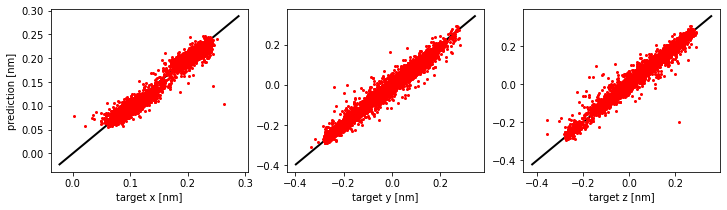

x: r2 0.9716836973860733 slope 0.9751210563704646 offset 0.0009096388260941002
y: r2 0.9801354324151414 slope 0.9755683999477953 offset -0.0024585888695659863
z: r2 0.966319259729968 slope 0.9672208071437175 offset 0.005538462020288543
CB


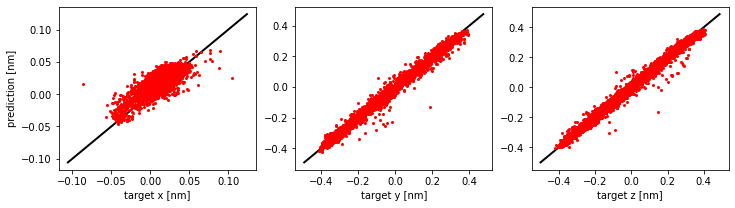

x: r2 0.7031624817296073 slope 0.7994529058520667 offset 0.010060462084326812
y: r2 0.9947920343297314 slope 0.9913576624746399 offset 0.0002502141327918872
z: r2 0.9900543635651238 slope 0.9852446123707249 offset -0.00040985959659563254


In [23]:
aa='SER'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCOCB") 

m = Model1D3_ca_n_co_cb()
m.apply(m.initialize_weights)
m.zero_grad()

# load partial weights from previous model
# may use other models previously trained 
m.load_state_dict(torch.load(f'{aa}_1d3_ca_n_co_predict_aa.dict'),strict=False)

# disable training of all weights
for param in m.parameters():
    param.requires_grad = False

# reenable training of only the second part of the network that predicts Cbetas 
# this means that the CA/N/CO prediction is not changed during training
for param in m.ccb_1.parameters():
    param.requires_grad = True
for param in m.ccb_2.parameters():
    param.requires_grad = True
for param in m.ccb_3.parameters():
    param.requires_grad = True
for param in m.ccb_4.parameters():
    param.requires_grad = True
for param in m.ccb_f.parameters():
    param.requires_grad = True   
for param in m.fccb_1.parameters():
    param.requires_grad = True
for param in m.fccb_2.parameters():
    param.requires_grad = True
for param in m.fccb_f.parameters():
    param.requires_grad = True

# optimizer with extra options to only train certain weights
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0005, weight_decay=0.00001)

epochs=20
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=2.0,klindex=12)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

print('CB')
plot_validation(vxyzloader,m,4)
linear_regression(vxyzloader,m,4)


torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_cb_predict_aa.dict")


(28328, 15)
0 0.0108842384070158 0.008393812616580123
1 0.006641633198079136 0.004146653245319715
2 0.0026088785147294403 0.001596344567618131
3 0.0014770632402764427 0.0012844975984416865
4 0.0012789147207513452 0.0011556544065143802
5 0.0012093635741621256 0.001175157608158192
6 0.0011531994147743615 0.0013865778728670605
7 0.0011317468338852955 0.0010802750314320333
8 0.0011159534889480305 0.001035069553176279
9 0.00110044652570246 0.001084531764191209
10 0.0010965804828123914 0.0011705122645218624
11 0.0010964096847197247 0.001207288414552878
12 0.001064826800332715 0.0010561814600608048
13 0.0010637336604607602 0.0010853568058906396
14 0.001078604034975999 0.0010666556637013193
15 0.0010691358694910175 0.0010376178434460964
16 0.0010474793806982538 0.001003694697824731
17 0.0010518061618010202 0.0010517408694231932
18 0.0010528857276464502 0.0010143591147667892
19 0.001076229121018615 0.0012427919614980947


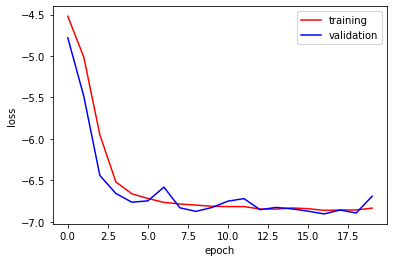

CA


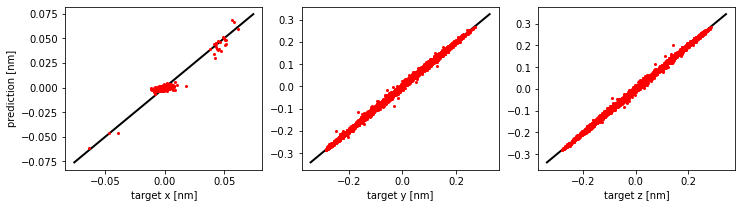

x: r2 0.8010070021950402 slope 0.7860788794419373 offset -2.887904614189584e-05
y: r2 0.999069799959152 slope 1.0025503259885804 offset 0.0014711830517867355
z: r2 0.9982112770041257 slope 1.0005407612231214 offset 0.0004928828910697944
N


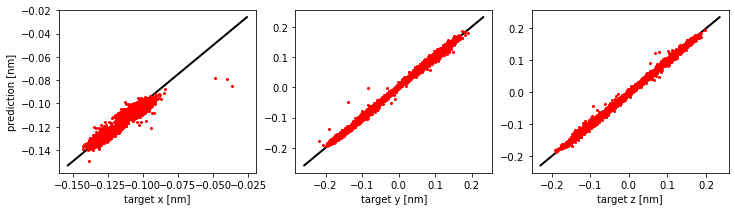

x: r2 0.9438742567369217 slope 0.9467040261724736 offset -0.006707991439882016
y: r2 0.9979300712262089 slope 1.0045430168288183 offset 0.0027575021826445126
z: r2 0.9969755122510903 slope 0.998355013435945 offset -0.0005420470466348023
C


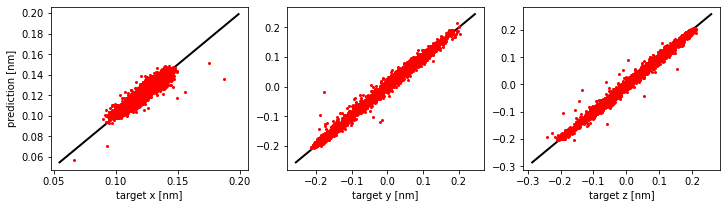

x: r2 0.889705557625849 slope 0.913140080018822 offset 0.010051731046267123
y: r2 0.993969829583495 slope 1.0002380423424313 offset 0.0031756701967224563
z: r2 0.9899950619206291 slope 0.9902307552503615 offset -0.0009691827808009264
O


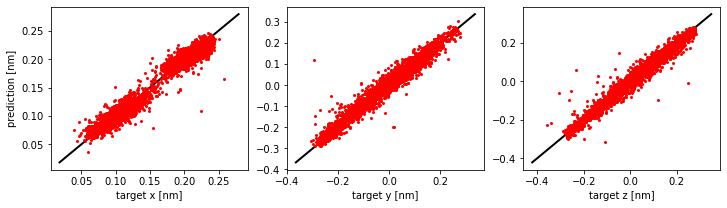

x: r2 0.9695937088172365 slope 0.9704798068337327 offset 0.002829073027763279
y: r2 0.9792799783998222 slope 0.9914695588231976 offset 0.005049485798556949
z: r2 0.9715581357769691 slope 0.9736306505082615 offset -0.00045790131786206667
CB


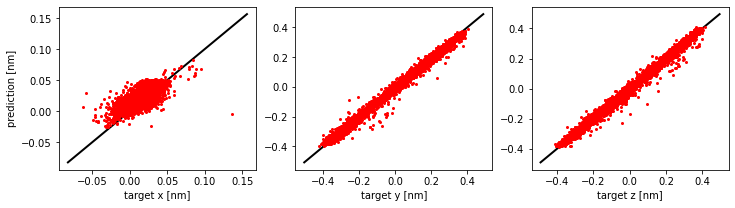

x: r2 0.6166324684484339 slope 0.7387476422485894 offset 0.01228786453483029
y: r2 0.9956952586194467 slope 0.984870974765623 offset -0.004475445738568402
z: r2 0.9911329939620588 slope 0.997519126227375 offset 0.0003538721914414858


In [24]:
aa='THR'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCOCB") 

m = Model1D3_ca_n_co_cb()
m.apply(m.initialize_weights)
m.zero_grad()

# load partial weights from previous model
# may use other models previously trained 
m.load_state_dict(torch.load(f'{aa}_1d3_ca_n_co_predict_aa.dict'),strict=False)

# disable training of all weights
for param in m.parameters():
    param.requires_grad = False

# reenable training of only the second part of the network that predicts Cbetas 
# this means that the CA/N/CO prediction is not changed during training
for param in m.ccb_1.parameters():
    param.requires_grad = True
for param in m.ccb_2.parameters():
    param.requires_grad = True
for param in m.ccb_3.parameters():
    param.requires_grad = True
for param in m.ccb_4.parameters():
    param.requires_grad = True
for param in m.ccb_f.parameters():
    param.requires_grad = True   
for param in m.fccb_1.parameters():
    param.requires_grad = True
for param in m.fccb_2.parameters():
    param.requires_grad = True
for param in m.fccb_f.parameters():
    param.requires_grad = True

# optimizer with extra options to only train certain weights
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0005, weight_decay=0.00001)

epochs=20
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=2.0,klindex=12)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

print('CB')
plot_validation(vxyzloader,m,4)
linear_regression(vxyzloader,m,4)


torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_cb_predict_aa.dict")
